# Data Science Workshop

# Data Loading

## Import Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import sklearn.linear_model as lm
from sklearn import metrics, preprocessing, svm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.decomposition import PCA

from outliers import smirnov_grubbs as grubbs

import random
import json
import time

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

## Reading the Income Classification Dataset

In [2]:
# read the entire file into a python array
with open('new_raw_data.json', 'rb') as f:
    data = f.readlines()
with open('photos.json', 'rb') as f:
    photos_data = f.readlines()
with open('not_self_feeds.json', 'rb') as f:
    feeds_data = f.readlines()
with open('self_feeds.json', 'rb') as f:
    posts_data = f.readlines()

# remove the trailing "\n" from each line
data = map(lambda x: x.rstrip(), data)
photos_data = map(lambda x: x.rstrip(), photos_data)
feeds_data = map(lambda x: x.rstrip(), feeds_data)
posts_data = map(lambda x: x.rstrip(), posts_data)

# each element of 'data' is an individual JSON object.
# i want to convert it into an *array* of JSON objects
# which, in and of itself, is one large JSON object
# basically... add square brackets to the beginning
# and end, and have all the individual business JSON objects
# separated by a comma
data_json_str = "[" + ','.join(data) + "]"
photos_data_json_str = "[" + ','.join(photos_data) + "]"
feeds_data_json_str = "[" + ','.join(feeds_data) + "]"
posts_data_json_str = "[" + ','.join(posts_data) + "]"

# now, load it into pandas
raw_data = pd.read_json(data_json_str)
photos_raw_data = pd.read_json(photos_data_json_str)
feeds_raw_data = pd.read_json(feeds_data_json_str)
posts_raw_data = pd.read_json(posts_data_json_str)

# join all data frames - used inner join to get rid of outdated pages (pages that got deleted between our queries)
raw_data = pd.merge(left=raw_data, right=photos_raw_data, how='inner', left_on='id', right_on='page_id')
raw_data = pd.merge(left=raw_data, right=posts_raw_data, how='inner', left_on='id', right_on='page_id')
# most pages didnt have any posts from other users/pages on their feed, so left join is used here
raw_data = pd.merge(left=raw_data, right=feeds_raw_data, how='left', left_on='id', right_on='page_id')

raw_data.drop(['page_id_x', 'page_id_y', 'page_id'], axis=1, inplace=True)

# Data preparation

In [3]:
ready_feats = [ 'has_cover_photo', 'has_profile_photo', 'id', 'likes', 'has_bio', 'has_birthday', 'has_company_overview',
                'has_about', 'has_hours', 'checkins', 'has_payment_options', 'search_category', 'has_mission', 'category',
#                 'category_list_len'
               
                # photo fields
                'photo_avg_comments_per_photo', 'photo_avg_likes_per_comments', 'photo_avg_likes_per_photo',
                'photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero', 
                'photo_count_has_name', 'photo_count_has_place', 'photo_distinct_uploaders', 
                'photo_max_like', 'photo_max_people_tagged', 'photo_min_like', 'photo_number_of_albums', 
                'photo_number_of_cover_albums', 'photo_number_of_different_months_for_photos', 'photo_number_of_null_albums', 
                'photo_number_of_other_albums', 'photo_number_of_photos_in_cover_albums', 'photo_number_of_photos_in_null_albums', 
                'photo_number_of_photos_in_other_albums', 'photo_number_of_photos_in_profile_albums', 
                'photo_number_of_profile_albums', 'total_photos', 'photo_number_of_days_between_first_and_last_photos',
               
                # feed fields
                'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_number_of_days_between_first_and_last_posts',
                'feed_avg_with_tagged_per_post', 'feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_count_has_place', 
                'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                'feed_post_updated_prc', 'feed_std_comments', 'feed_std_likes', 'feed_sum_people_tagged_count', 
                'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares', 'feed_std_shares',
                'feed_distinct_post_writers', 'feed_post_count',

                # posts fields
                'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_likes_per_comment',                           
                'self_feed_avg_people_tagged_per_post', 'self_feed_avg_people_tagged_per_post_with_more_than_zero',  
                'self_feed_number_of_days_between_first_and_last_posts', 'self_feed_avg_with_tagged_per_post',                        
                'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'self_feed_count_has_place',                                 
                'self_feed_count_post_updated', 'self_feed_is_published_count', 'self_feed_max_comments',
                'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_number_of_added_photos_category',                 
                'self_feed_number_of_different_months_for_post', 'self_feed_number_of_null_category', 'self_feed_number_of_other_categories',                      
                'self_feed_number_of_shared_story_category', 'self_feed_post_max_people_tagged', 'self_feed_post_max_with_tagged',                            
                'self_feed_post_updated_prc', 'self_feed_std_comments', 'self_feed_std_likes', 'self_feed_sum_people_tagged_count',                         
                'self_feed_sum_with_tagged_count', 'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares',                                      
                'self_feed_std_shares', 'self_post_count'
              ]

all_data = raw_data[ready_feats].copy()

# merge identical columns
all_data['general_info'] = pd.concat([raw_data['generalInfo'].dropna(), raw_data['general_info'].dropna()]).reindex_like(raw_data)
all_data['is_permanently_closed'] = pd.concat([raw_data['isPermanentlyClosed'].dropna(), raw_data['is_permanently_closed'].dropna()]).reindex_like(raw_data)
all_data['is_unclaimed'] = pd.concat([raw_data['isUnclaimed'].dropna(), raw_data['is_unclaimed'].dropna()]).reindex_like(raw_data)
all_data['is_verified'] = pd.concat([raw_data['isVerified'].dropna(), raw_data['is_verified'].dropna()]).reindex_like(raw_data)
all_data['price_range'] = pd.concat([raw_data['priceRange'].dropna(), raw_data['price_range'].dropna()]).reindex_like(raw_data)
all_data['start_info'] = pd.concat([raw_data['startInfo'].dropna(), raw_data['start_info'].dropna()]).reindex_like(raw_data)
all_data['talking_about_count'] = pd.concat([raw_data['talkingAboutCount'].dropna(), raw_data['talking_about_count'].dropna()]).reindex_like(raw_data)
all_data['were_here_count'] = pd.concat([raw_data['wereHereCount'].dropna(), raw_data['were_here_count'].dropna()]).reindex_like(raw_data)

# create 'has' columns
all_data['has_email'] = raw_data['emails'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_phone'] = raw_data['phone'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_website'] = raw_data['website'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_location'] = raw_data['location'].apply(lambda x: type(x) != np.float and len(x) > 0)
all_data['has_description'] = raw_data['description'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_general_info'] = all_data['general_info'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['has_products'] = raw_data['products'].apply(lambda x: len(x) > 0 if type(x) != np.float else False)
all_data['self_feed_has_unpublished'] = all_data[['self_post_count','self_feed_is_published_count']].apply(lambda x: x['self_post_count'] == x['self_feed_is_published_count'], 1)

# create 'num of words' columns
all_data['name_num_of_words'] = raw_data['name'].apply(lambda x: len(x.split()) if type(x) != np.float else np.nan)

# parse complex vars
all_data['location_city'] = raw_data['location'].apply(lambda x: x['city'] if (type(x) != np.float and 'city' in x) else np.nan)
all_data['location_city'].fillna(raw_data['hometown'], inplace=True)
all_data['location_country'] = raw_data['location'].apply(lambda x: x['country'] if (type(x) != np.float and 'country' in x) else np.nan)
all_data['start_info'] = all_data['start_info'].apply(lambda x: x['date']['year'] if (type(x) != np.float and 'date' in x and 'year' in x['date']) else np.nan)
all_data['price_range'] = all_data['price_range'].apply(lambda x: len(x) if type(x) != np.float else np.nan)

category_mapping = {'Bank': 'business', 'Bar': 'life_style', 'Beauty': 'life_style', 'Beverages': 'food', 'Book': 'entertainment', 'Business': 'business', 'Character': 'entertainment', 'Church': 'organization', 'Coffee': 'life_style', 'Company': 'business', 'Equipment': 'industrial', 'Event': 'organization', 'Financial': 'business', 'Foo': 'food', 'Food': 'food', 'Goods': 'life_style', 'Government': 'organization', 'Health': 'life_style', 'Materials': 'industrial', 'Movie': 'entertainment', 'Music': 'entertainment', 'Organization': 'organization', 'Pet': 'life_style', 'Political': 'organization', 'Public': 'organization', 'School': 'organization', 'Services': 'business', 'Sports': 'entertainment', 'Supplies': 'industrial', 'TV': 'entertainment', 'Team': 'entertainment', 'Venue': 'organization', 'Video': 'entertainment'}        
all_data['main_category'] = all_data['search_category'].map(category_mapping)

# frequency related features - move to feature eng
all_data['photo_upload_freq'] = all_data.apply(lambda x: x['photo_number_of_days_between_first_and_last_photos']/x['total_photos'] if x['photo_number_of_days_between_first_and_last_photos'] != np.nan and x['total_photos'] != np.nan else 0, axis=1)
all_data['feed_update_freq'] = all_data.apply(lambda x: x['feed_number_of_days_between_first_and_last_posts']/x['feed_post_count'] if x['feed_number_of_days_between_first_and_last_posts'] != np.nan and x['feed_post_count'] != np.nan else 0, axis=1)
all_data['posting_freq'] = all_data.apply(lambda x: x['self_feed_number_of_days_between_first_and_last_posts']/x['self_post_count'] if x['self_feed_number_of_days_between_first_and_last_posts'] != np.nan and x['self_post_count'] != np.nan else 0, axis=1)

# convert types
all_data['founded'] = raw_data['founded'].apply(lambda x: np.int64(x) if (type(x) == unicode and x.strip().isdigit()) else np.nan)

# drop duplicate pages (we got some pages twice because we queried by page category and some pages were in several categrories)
all_data.drop_duplicates(subset='id', keep='last', inplace=True)

## Missing Data Imputation

In [4]:
print "Missing data by column (total rows %s):" % all_data.id.count()
missing_count = all_data.isnull().sum().sort_values(ascending=False)
print missing_count[missing_count.nonzero()[0]]

Missing data by column (total rows 12773):
feed_avg_with_tagged_per_post_with_more_than_zero           12505
feed_avg_people_tagged_per_post_with_more_than_zero         12031
feed_std_shares                                             11708
general_info                                                11504
self_feed_avg_with_tagged_per_post_with_more_than_zero      10936
founded                                                     10892
feed_avg_shares                                             10603
feed_max_shares                                             10603
feed_min_shares                                             10603
price_range                                                  9660
feed_avg_people_tagged_per_post                              8470
feed_number_of_days_between_first_and_last_posts             8470
feed_avg_with_tagged_per_post                                8470
feed_post_max_people_tagged                                  8470
feed_post_max_with_tagged        

In [5]:
# drop features too sparse or that have no meaningful way to fill
feats_to_drop = ['founded', 'start_info', 'general_info', 'feed_avg_with_tagged_per_post_with_more_than_zero', 
                 'feed_avg_people_tagged_per_post_with_more_than_zero', 'feed_std_shares', 
                 'self_feed_avg_with_tagged_per_post_with_more_than_zero', 'feed_post_updated_prc']
all_data.drop(feats_to_drop, axis = 1, inplace=True)

# NaN to 0
numeric_impute = [  'photo_avg_people_tagged_per_photo_with_more_than_zero', 'price_range',
                  
                    'feed_avg_comments', 'feed_avg_likes', 'feed_avg_likes_per_comment', 'feed_avg_people_tagged_per_post', 
                    'feed_number_of_days_between_first_and_last_posts',
                    'feed_avg_with_tagged_per_post', 'feed_count_has_place', 
                    'feed_count_post_updated', 'feed_is_published_count', 'feed_max_comments', 
                    'feed_max_likes', 'feed_min_comments', 'feed_min_likes', 'feed_number_of_added_photos_category', 
                    'feed_number_of_different_months_for_post', 'feed_number_of_null_category', 'feed_number_of_other_categories', 
                    'feed_number_of_shared_story_category', 'feed_post_max_people_tagged', 'feed_post_max_with_tagged', 
                    'feed_std_comments', 'feed_std_likes', 
                    'feed_sum_with_tagged_count', 'feed_avg_shares', 'feed_max_shares', 'feed_min_shares',
                    'feed_distinct_post_writers', 'feed_post_count', 'feed_update_freq', 'feed_sum_people_tagged_count',
                    
                    'self_feed_avg_comments', 'self_feed_avg_likes', 'self_feed_avg_people_tagged_per_post', 
                    'self_feed_avg_people_tagged_per_post_with_more_than_zero', 'self_feed_number_of_days_between_first_and_last_posts', 
                    'self_feed_avg_with_tagged_per_post', 'self_feed_max_comments', 
                    'self_feed_max_likes', 'self_feed_min_comments', 'self_feed_min_likes', 'self_feed_post_max_people_tagged', 
                    'self_feed_post_max_with_tagged', 'self_feed_std_comments', 'self_feed_std_likes',  
                    'self_feed_avg_shares', 'self_feed_max_shares', 'self_feed_min_shares', 
                    'self_feed_std_shares', 'posting_freq', 'self_feed_sum_people_tagged_count', 'self_feed_sum_with_tagged_count'
                 ]
all_data[numeric_impute] = all_data[numeric_impute].fillna(0) 

# fill missing countries by city
all_data['location_country'].fillna('empty', inplace=True)
all_data['location_city'].fillna('empty', inplace=True)
temp = {k: g["location_country"].tolist() for k,g in all_data.groupby("location_city")}
city_to_country = {}
for city, countries in temp.items():
    if city == 'empty':
        city_to_country[city] = 'empty'
        continue
    for country in countries:
        if country != 'empty':
            city_to_country[city] = country
            break
    if city_to_country.get(city) is None:
        city_to_country[city] = 'empty'
all_data['location_country'] = all_data.apply(lambda x: x['location_country'] if x['location_country'] != 'empty' else city_to_country[x['location_city']], axis=1)
all_data['location_country'].fillna('empty', inplace=True)
val_count = all_data['location_country'].value_counts()
all_data['country'] = all_data.location_country.apply(lambda x: x if val_count[x] > 150 else 'other')
all_data.drop(['location_city', 'location_country'], axis = 1, inplace=True)

continent_mapping = {'United States': 'America', 'Thailand': 'Asia', 'Australia': 'Australia', 'Bangladesh': 'Asia', 'Brazil': 'America', 'Cambodia': 'Asia', 'Egypt': 'Africa', 'India': 'Asia', 'Israel': 'Asia', 'Mexico': 'America', 'Myanmar': 'Africa', 'Pakistan': 'Asia', 'Philippines': 'Asia', 'South Africa': 'Africa', 'United Kingdom': 'Europe', 'Vietnam': 'Asia', 'empty': 'Global', 'other': 'Europe'}
all_data['continent'] = all_data.country.map(continent_mapping)

print "Columns with missing data: ", all_data.isnull().sum().nonzero()[0]

Columns with missing data:  []


## Types Conversion

In [6]:
binary_variables = ['has_email', 'has_phone', 'has_website', 'has_location', 
                    'is_permanently_closed', 'is_unclaimed', 'is_verified', 'has_description', 
                    'has_general_info', 'has_products', 'self_feed_has_unpublished']

for variable in binary_variables:
    all_data[variable] = all_data[variable].astype(int)
    
for feat in all_data.columns.get_values():
    print "%s\t%s\t%s" % (all_data.columns.get_loc(feat), all_data.dtypes[all_data.columns.get_loc(feat)], feat)

0	int64	has_cover_photo
1	int64	has_profile_photo
2	int64	id
3	int64	likes
4	int64	has_bio
5	int64	has_birthday
6	int64	has_company_overview
7	int64	has_about
8	int64	has_hours
9	int64	checkins
10	int64	has_payment_options
11	object	search_category
12	int64	has_mission
13	object	category
14	float64	photo_avg_comments_per_photo
15	float64	photo_avg_likes_per_comments
16	float64	photo_avg_likes_per_photo
17	float64	photo_avg_people_tagged_per_photo
18	float64	photo_avg_people_tagged_per_photo_with_more_than_zero
19	int64	photo_count_has_name
20	int64	photo_count_has_place
21	int64	photo_distinct_uploaders
22	int64	photo_max_like
23	int64	photo_max_people_tagged
24	int64	photo_min_like
25	int64	photo_number_of_albums
26	int64	photo_number_of_cover_albums
27	int64	photo_number_of_different_months_for_photos
28	int64	photo_number_of_null_albums
29	int64	photo_number_of_other_albums
30	int64	photo_number_of_photos_in_cover_albums
31	int64	photo_number_of_photos_in_null_albums
32	int64	photo_

# Data Cleaning

In [7]:
def get_features_to_analyze():
    features = all_data.columns.get_values().tolist()
    features_to_remove = ['likes', 'country', 'search_category', 'category', 'main_category', 'continent']
    return [a for a in features if a not in features_to_remove]

### Remove features with low std

In [8]:
features = get_features_to_analyze()
stds = {}

for feat in features:
    curr_std = all_data[feat].std()
    stds[feat] = curr_std
    
sorted_by_std = sorted(stds.items(), key=lambda x: x[1])
low_std = [a for a in sorted_by_std if a[1] < 0.3]
for a in low_std:
    print a[0] + " -- with std of: " + str(a[1])

photo_number_of_photos_in_null_albums -- with std of: 0.0
has_profile_photo -- with std of: 0.0
photo_number_of_null_albums -- with std of: 0.0
photo_distinct_uploaders -- with std of: 0.0
is_permanently_closed -- with std of: 0.0176942650361
is_unclaimed -- with std of: 0.0197820150598
feed_number_of_null_category -- with std of: 0.0586643438236
has_bio -- with std of: 0.137166483067
feed_avg_people_tagged_per_post -- with std of: 0.150598145682
self_feed_post_updated_prc -- with std of: 0.161076721316
self_feed_has_unpublished -- with std of: 0.16550599025
has_payment_options -- with std of: 0.207863823005
has_about -- with std of: 0.236568340661
has_website -- with std of: 0.279276120539
has_general_info -- with std of: 0.299143338765


In [9]:
zero_std_features = [a[0] for a in sorted_by_std if a[1] == 0]

# remove permanently_closed and is_unclaimed pages
all_data = all_data[all_data['is_permanently_closed'] != 1].reset_index(drop=True)
all_data = all_data[all_data['is_unclaimed'] != 1].reset_index(drop=True)
low_std_features = zero_std_features + ['is_permanently_closed', 'is_unclaimed', 'feed_number_of_null_category']

# drop features with low std
all_data.drop(low_std_features, axis=1, inplace=True)

### Remove too correlated features

In [10]:
features = get_features_to_analyze()

corrs = {}
threshold = 0.9

for i in range(len(features)):
    for j in range(i+1,len(features)):
        curr_corr = np.corrcoef(all_data[features[i]], all_data[features[j]])
        c = curr_corr[0][1]
        if c > threshold or c < -(threshold):
            corrs[(features[i],features[j])] = c
            
sorted_by_corr = sorted(corrs.items(), key=lambda x: x[1], reverse=True)
for a in sorted_by_corr:
        print a[0][0] + " and " + a[0][1] + " -- with correlation of: " + str(a[1])

        

feed_is_published_count and feed_post_count -- with correlation of: 1.0
self_feed_is_published_count and self_post_count -- with correlation of: 0.999902425984
feed_is_published_count and feed_distinct_post_writers -- with correlation of: 0.982135591891
feed_distinct_post_writers and feed_post_count -- with correlation of: 0.982135591891
self_feed_avg_people_tagged_per_post and self_feed_sum_people_tagged_count -- with correlation of: 0.979943565264
feed_max_likes and feed_std_likes -- with correlation of: 0.974911796454
photo_number_of_photos_in_other_albums and total_photos -- with correlation of: 0.97016025273
self_feed_avg_with_tagged_per_post and self_feed_sum_with_tagged_count -- with correlation of: 0.967020046602
photo_number_of_albums and photo_number_of_other_albums -- with correlation of: 0.953475312032
self_feed_max_likes and self_feed_std_likes -- with correlation of: 0.93922959203
feed_post_max_with_tagged and feed_sum_with_tagged_count -- with correlation of: 0.930935953

In [11]:
all_data['self_feed_has_unpublished'] = all_data.apply(lambda x: x['self_post_count'] != x['self_feed_is_published_count'], 1)


# drop features too correlated
too_coor_feats = ['feed_is_published_count', 'self_feed_is_published_count', 'feed_distinct_post_writers',
                  'photo_number_of_photos_in_other_albums', 
                  'self_feed_sum_with_tagged_count', 'self_feed_sum_people_tagged_count',
                  'feed_sum_people_tagged_count', 'feed_sum_with_tagged_count']
all_data.drop(too_coor_feats, axis=1, inplace=True)

# Data Exploration

### Data Exploration utils

In [12]:
def show_numric_features(features):
    for key in features.keys():
        key_dict = features.get(key)
        col = key_dict.get('column')
        data_to_show = all_data[(all_data[col] >= key_dict.get('lower_bound')) & 
                              (all_data[col] <= key_dict.get('upper_bound'))][col]

        sns.distplot(data_to_show, 
                     bins = key_dict.get('bins'), kde = key_dict.get('kde'), label = key)
        plt.title('Histogram of ' + key)
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.legend(loc="upper right")
        plt.show()

def show_log_numric_features(features):
    for col in features:
        data_to_show = all_data[(all_data[col] > 0)][col]
        log_data_to_show = data_to_show.apply(lambda x: np.log(x)).to_frame('log_' + col)
        sns.distplot(log_data_to_show, label = col)
        plt.title('Histogram of log ' + col)
        plt.xlabel('log_' + col)
        plt.ylabel('Count')
        plt.legend(loc="upper right")
        plt.show()

def show_categorical_features(features):
    for feat in features:
        data_to_show = all_data[[feat]]
        unique_values = data_to_show[feat].unique().tolist()
        unique_values.sort()
        if (unique_values == [0,1]):
            data_to_show = data_to_show.astype(bool)
        sns.plt.title(feat + ' count')
        ax = sns.countplot(feat, data=data_to_show) #,color='purple')
        sns.plt.show()

def show_categorical_data(data):
    for df in data:
        feat = df.columns.tolist()[0]
        ax = sns.countplot(feat, data=df)
        sns.plt.show()

def show_correlation(columns):
    data = all_data[columns]
    pd.tools.plotting.scatter_matrix(data, alpha = 0.6, figsize = (10,10), diagonal = 'kde')
    plt.show()


def show_scatter(data,op=0):
    keys = data.keys()
    if op == 0:
        col1 = keys[0]
        col2 = keys[1]
    else:
        col1 = keys[1]
        col2 = keys[0]
    sns.set(color_codes=True)
    scatter = pd.DataFrame()
    data_to_show = all_data[(all_data[col1] >= data[col1][0]) & (all_data[col1] < data[col1][1]) & 
                             (all_data[col2] >= data[col2][0]) & (all_data[col2] < data[col2][1])]
    scatter[col1] = data_to_show[col1]
    scatter[col2] = data_to_show[col2]
    rows = random.sample(scatter.index, 1000)
    scatter_10 = scatter.ix[rows]
    sns.regplot(col1, col2, scatter_10, 
                scatter_kws={"marker": ".", "color": "green"},
                line_kws = {"linewidth": "1", "color": "green"},
                order = 2, label = 'points')
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.legend(loc="lower right")
    plt.title("Scatter plot of " + col1 + " and " + col2)
    plt.show()

In [13]:
for feat in all_data.columns.get_values():
    if feat != 'id':
        print "==============================================="
        print all_data[feat].describe()

count   12,764.00
mean         0.19
std          0.39
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_cover_photo, dtype: float64
count        12,764.00
mean        429,905.08
std       2,216,464.40
min               0.00
25%           9,192.25
50%          38,107.50
75%         172,433.25
max     102,762,547.00
Name: likes, dtype: float64
count   12,764.00
mean         0.02
std          0.14
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_bio, dtype: float64
count   12,764.00
mean         0.19
std          0.40
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_birthday, dtype: float64
count   12,764.00
mean         0.12
std          0.33
min          0.00
25%          0.00
50%          0.00
75%          0.00
max          1.00
Name: has_company_overview, dtype: float64
count   12,764.00
mean         0.94
std          0.24
min         

### Likes

count        12,764.00
mean        429,905.08
std       2,216,464.40
min               0.00
25%           9,192.25
50%          38,107.50
75%         172,433.25
max     102,762,547.00
Name: likes, dtype: float64


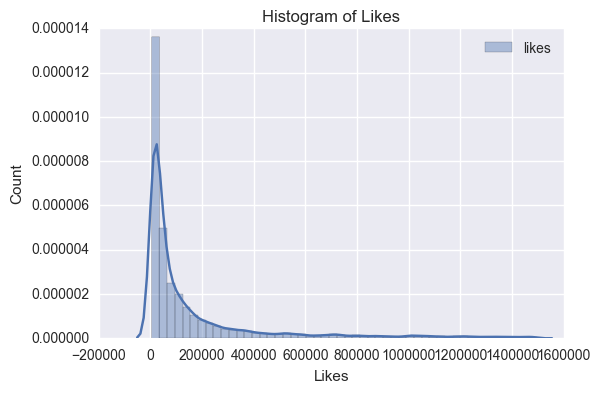

count   12,756.00
mean        10.60
std          2.26
min          0.00
25%          9.13
50%         10.55
75%         12.06
max         18.45
Name: likes, dtype: float64


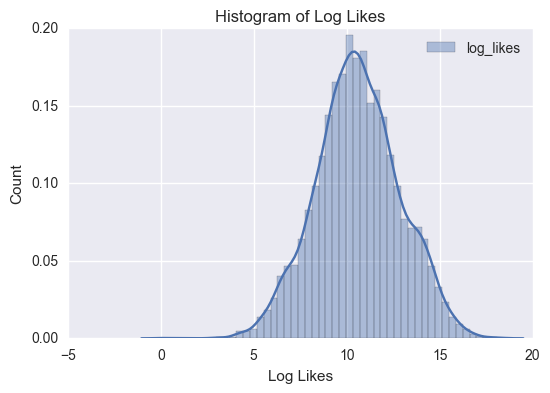

skewness: -0.00136172485706
kurtosis: -0.0225753909844 



In [14]:
print all_data.likes.describe()
sns.distplot(all_data[(all_data['likes'] > 5000) & (all_data['likes'] < 1500000)].likes, 
             bins = 50, kde = True, label = "likes")
plt.title('Histogram of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

log_likes = all_data[all_data['likes'] > 0]['likes'].apply(lambda x: np.log(x))
print log_likes.describe()

sns.distplot(log_likes, bins = 50, kde = True, label = "log_likes")
plt.title('Histogram of Log Likes')
plt.xlabel('Log Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

print "skewness:", log_likes.skew()
print "kurtosis:", log_likes.kurtosis(), '\n'


       self_feed_avg_likes
count            12,498.00
mean                  0.00
std                   1.00
min                  -4.22
25%                  -0.72
50%                  -0.01
75%                   0.71
max                   3.43


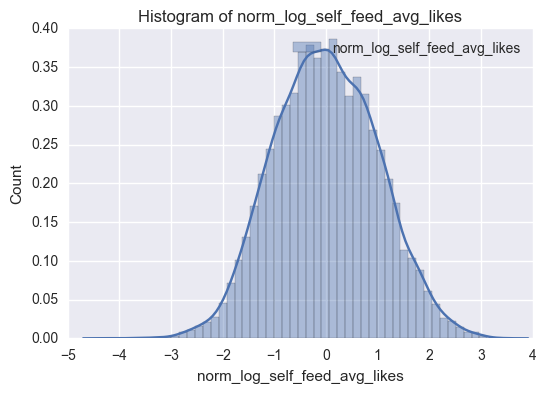

skewness: self_feed_avg_likes   0.05
dtype: float64
kurtosis: self_feed_avg_likes   -0.23
dtype: float64 



In [15]:
data_to_show = all_data[all_data['self_feed_avg_likes'] > 0]['self_feed_avg_likes'] 
log_self_feed_avg_likes = data_to_show.apply(lambda x: np.log(x)).to_frame('self_feed_avg_likes')
# print log_self_feed_avg_likes.describe()
log_self_feed_avg_likes_mean = log_self_feed_avg_likes.mean()
log_self_feed_avg_likes_std = log_self_feed_avg_likes.std()



norm_log_self_feed_avg_likes = log_self_feed_avg_likes['self_feed_avg_likes'].apply(lambda x: (x - log_self_feed_avg_likes_mean) / (log_self_feed_avg_likes_std))
print norm_log_self_feed_avg_likes.describe()
sns.distplot(norm_log_self_feed_avg_likes, bins = 50, kde = True, label = "norm_log_self_feed_avg_likes")
plt.title('Histogram of norm_log_self_feed_avg_likes')
plt.xlabel('norm_log_self_feed_avg_likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

print "skewness:", norm_log_self_feed_avg_likes.skew()
print "kurtosis:", norm_log_self_feed_avg_likes.kurtosis(), '\n'

### Genral Info features

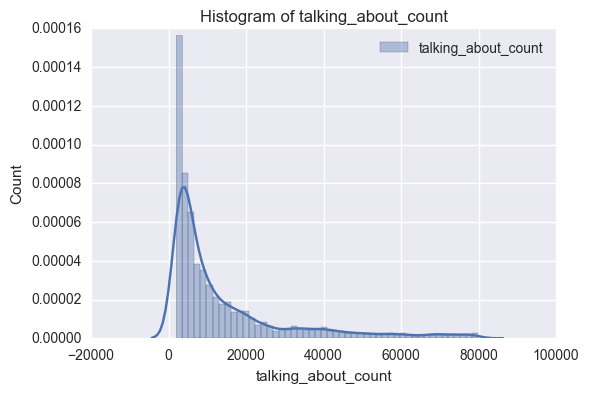

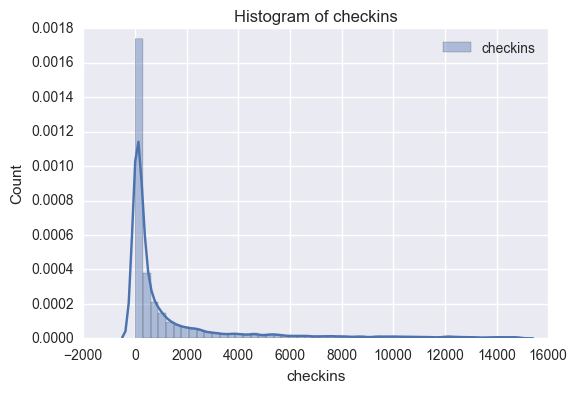

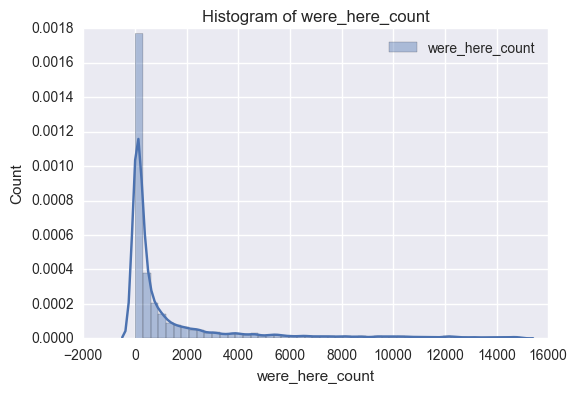

In [16]:
page_numric_features = {'talking_about_count':{'column': 'talking_about_count','lower_bound': 2000, 'upper_bound': 80000, 'bins': 50, 'kde': True},
        'were_here_count':{'column': 'were_here_count','lower_bound': 10, 'upper_bound': 15000, 'bins': 50, 'kde': True},
        'checkins': {'column': 'checkins','lower_bound': 10, 'upper_bound': 15000, 'bins': 50, 'kde': True}}
show_numric_features(page_numric_features)


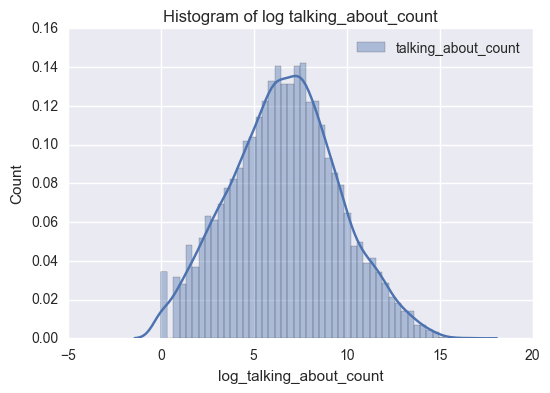

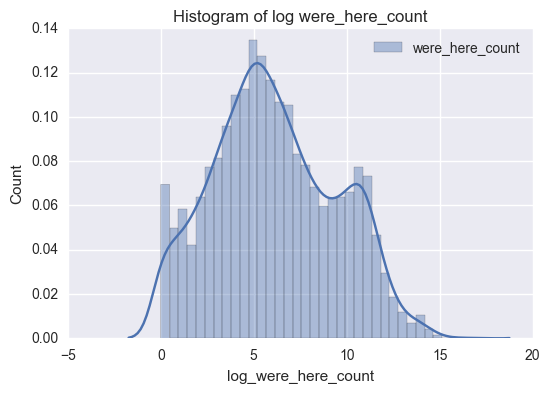

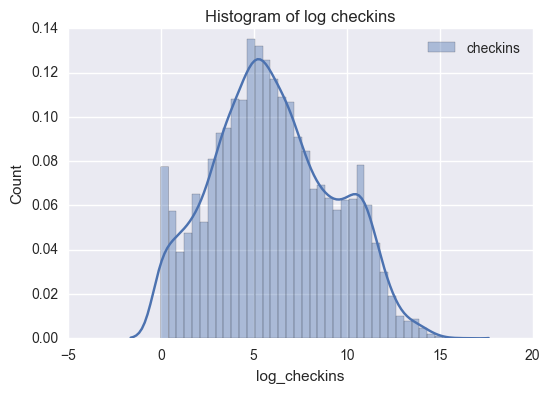

In [17]:
page_exp_features = ['talking_about_count', 'were_here_count', 'checkins']
show_log_numric_features(page_exp_features)

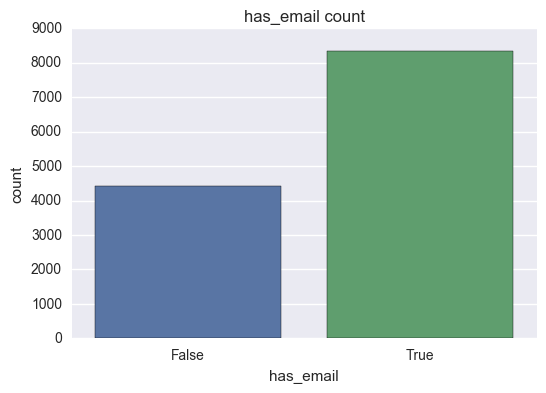

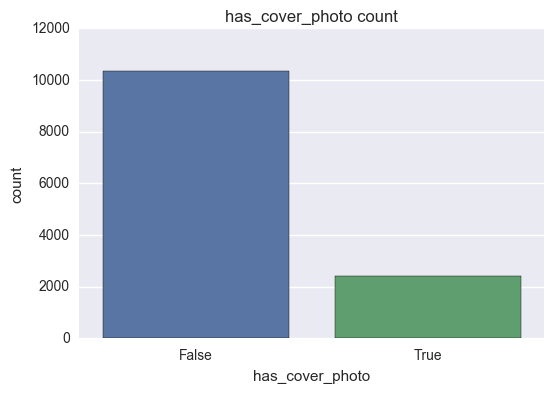

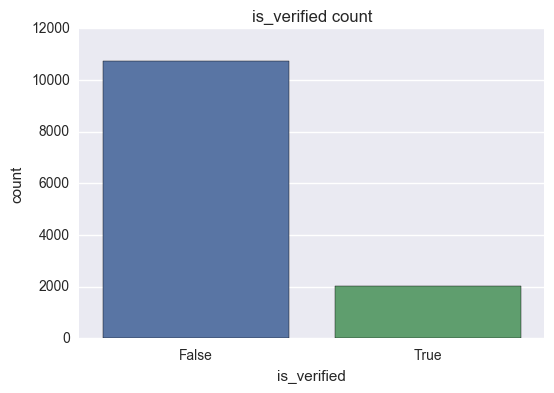

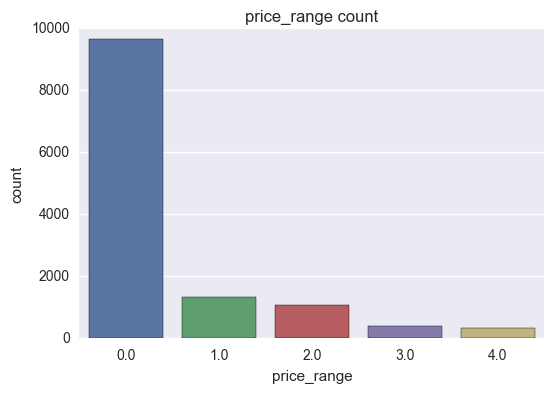

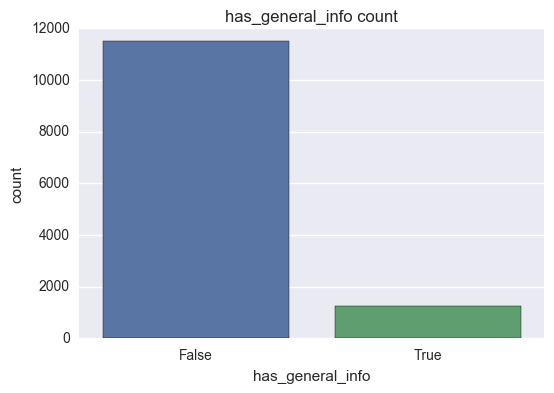

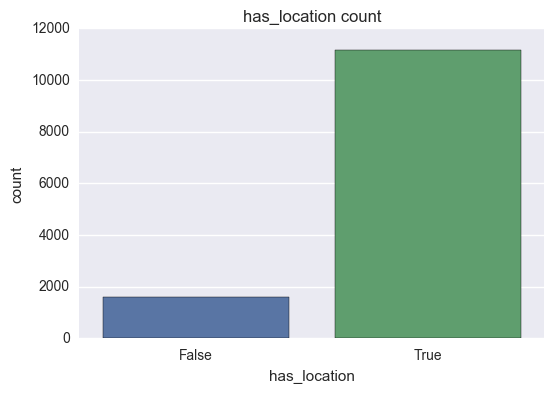

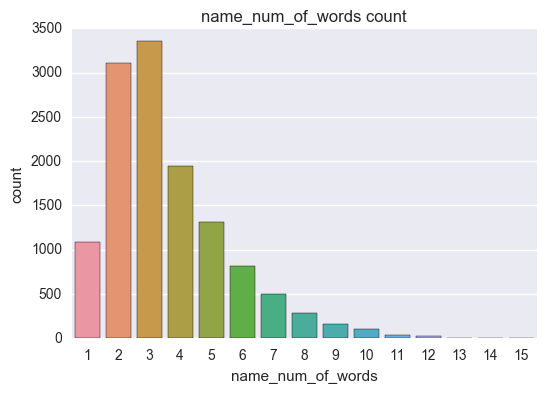

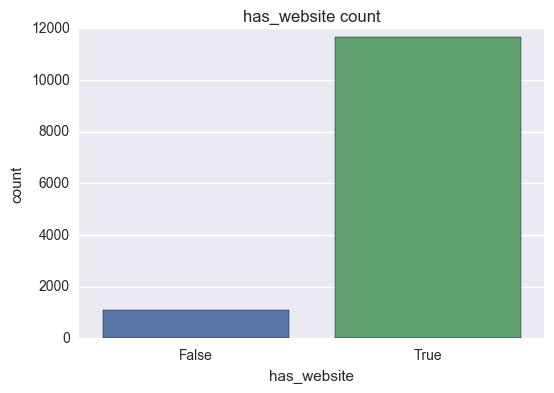

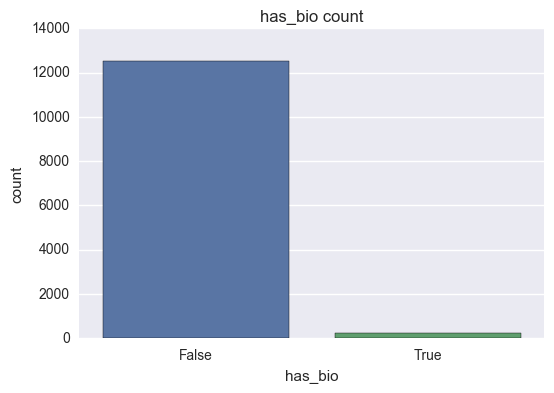

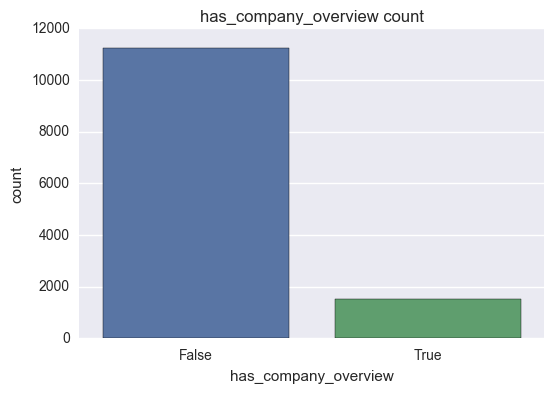

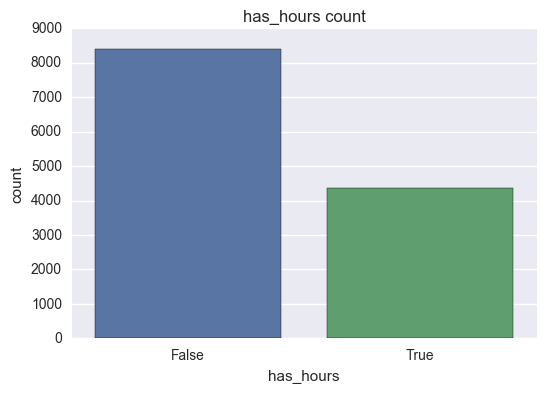

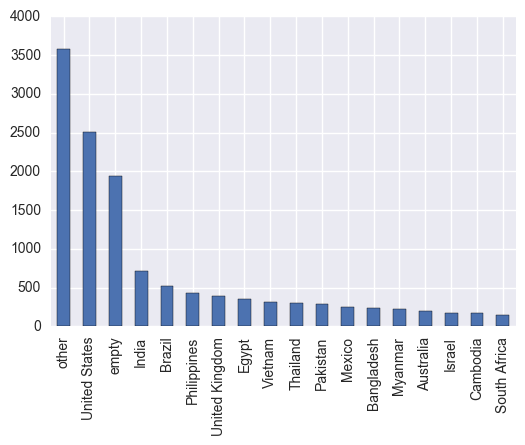

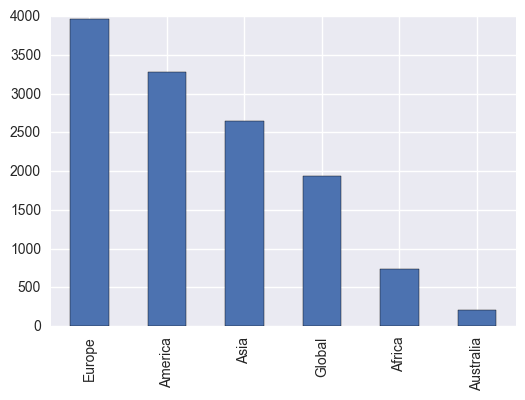

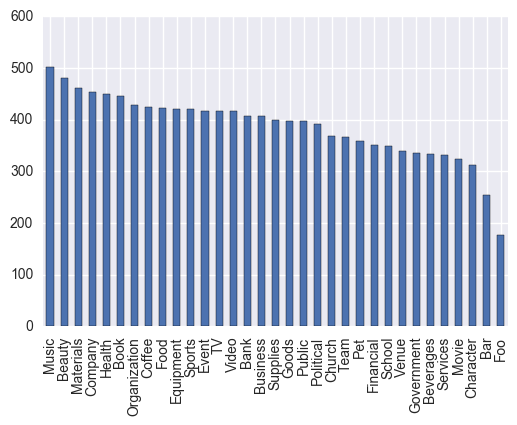

In [18]:
page_categorical_features = ['has_email', 'has_cover_photo', 'is_verified', 'price_range', 
                             'has_general_info', 'has_location', 'name_num_of_words', 'has_website',
                            'has_bio', 'has_company_overview', 'has_hours']

show_categorical_features(page_categorical_features)

# countries count plot
countries = all_data['country'].value_counts().plot(kind='bar')
plt.show()

# continent count plot
continents = all_data['continent'].value_counts().plot(kind='bar')
plt.show()

search_categories = all_data['search_category'].value_counts().plot(kind='bar')
plt.show()


### Self Feed Features

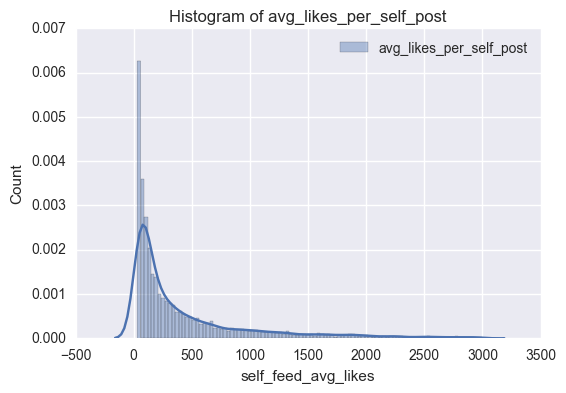

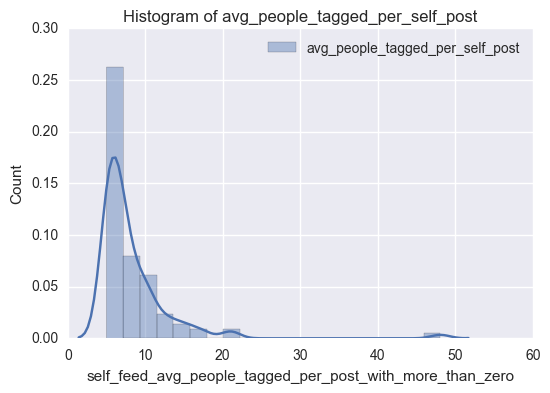

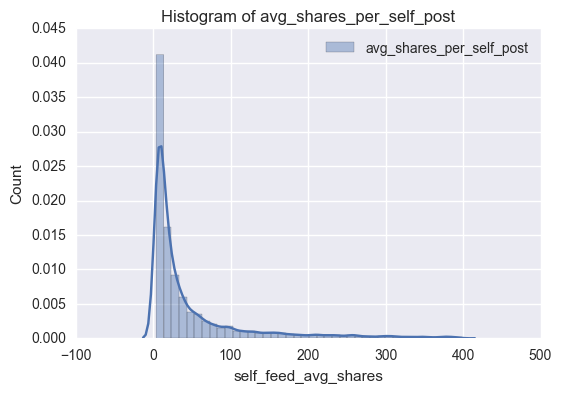

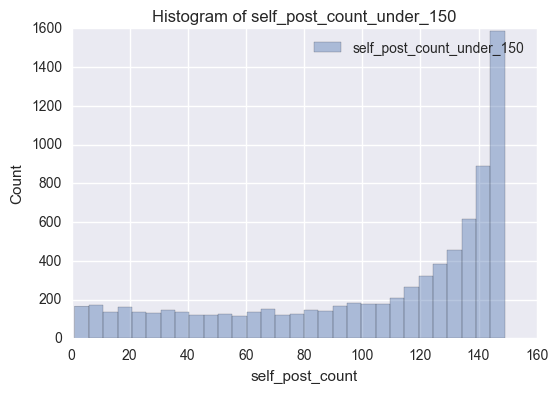

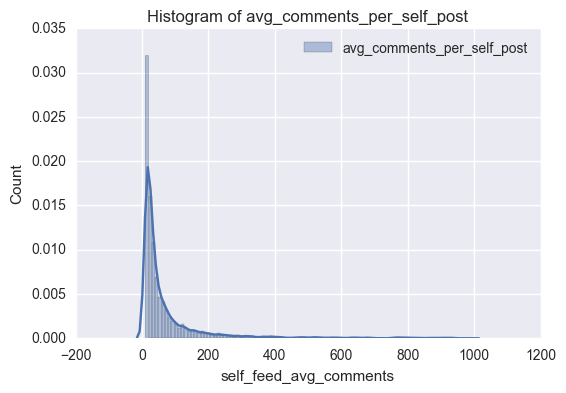

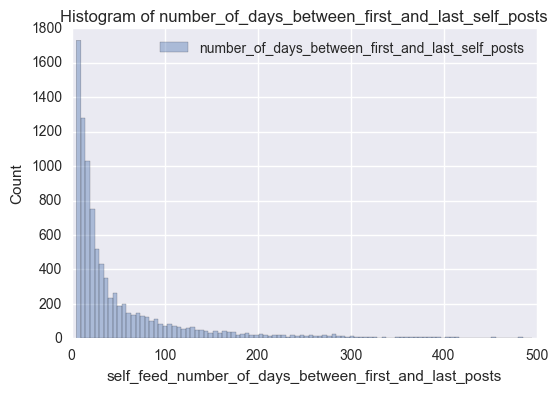

In [19]:
self_feed_numric_features = {'self_post_count_under_150':{'column': 'self_post_count','lower_bound': 0, 'upper_bound': 149, 'bins': 30, 'kde': False},
                        'avg_likes_per_self_post':{'column': 'self_feed_avg_likes','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_comments_per_self_post': {'column': 'self_feed_avg_comments','lower_bound': 10, 'upper_bound': 1000, 'bins': 100, 'kde': True},
                        'avg_shares_per_self_post': {'column': 'self_feed_avg_shares','lower_bound': 4, 'upper_bound': 400, 'bins': 40, 'kde': True},

                        #'max_comments_per_post': {'column': 'feed_max_comments','lower_bound': 50, 'upper_bound': 5000, 'bins': 100, 'kde': True},
                        'avg_people_tagged_per_self_post':{'column': 'self_feed_avg_people_tagged_per_post_with_more_than_zero','lower_bound': 5, 'upper_bound': 100, 'bins': 20, 'kde': True},
                        'number_of_days_between_first_and_last_self_posts': {'column': 'self_feed_number_of_days_between_first_and_last_posts','lower_bound': 5, 'upper_bound': 500, 'bins': 100, 'kde': False}}

show_numric_features(self_feed_numric_features)


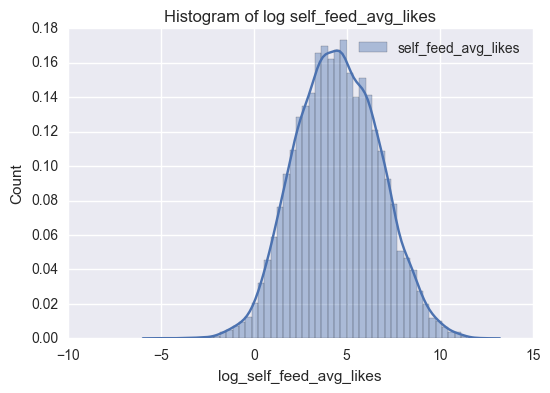

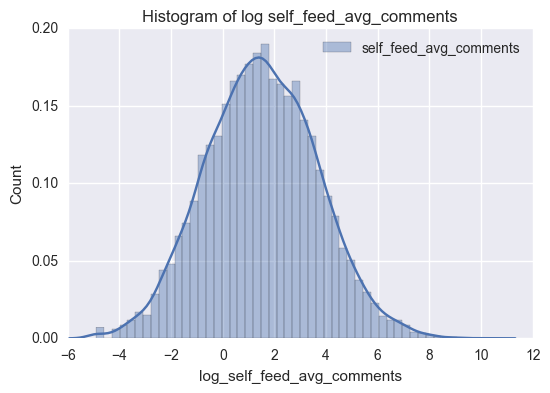

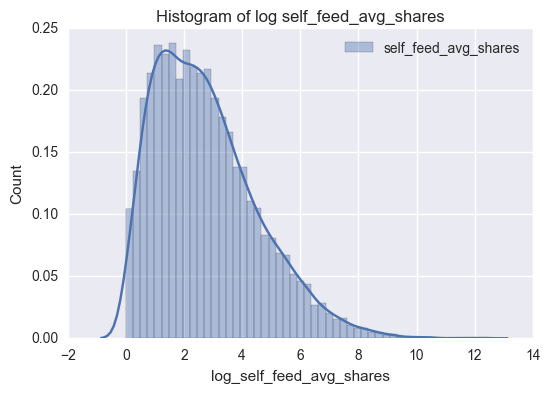

In [20]:
self_feed_exp_features = ['self_feed_avg_likes','self_feed_avg_comments', 'self_feed_avg_shares']   
show_log_numric_features(self_feed_exp_features) 

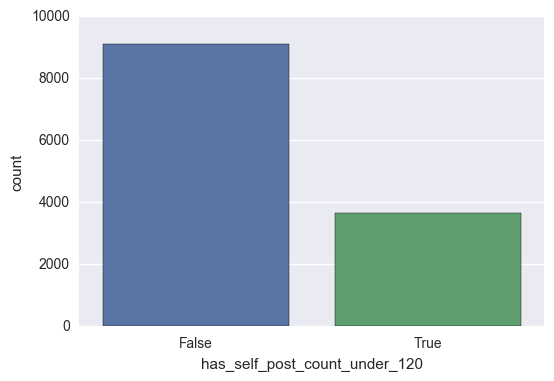

In [21]:
data = [all_data['self_post_count'].apply(lambda x: True if x < 120 else False).to_frame('has_self_post_count_under_120')]
show_categorical_data(data)

### Feed features

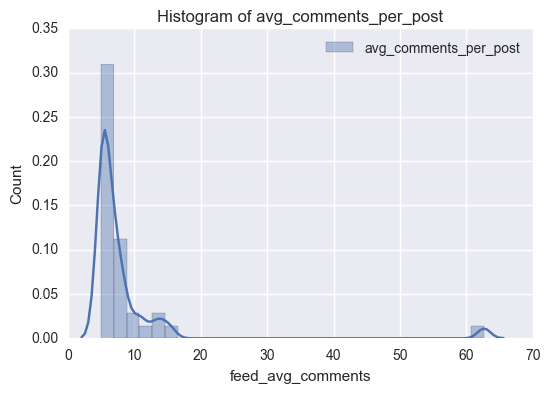

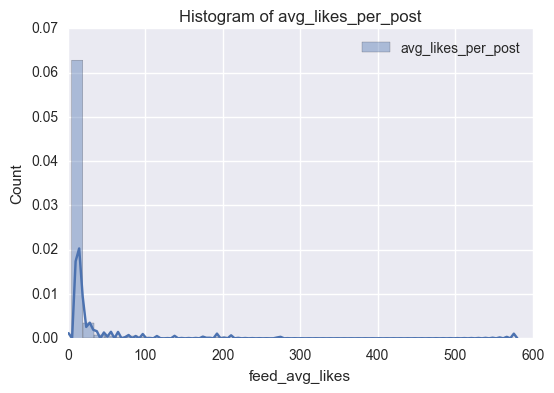

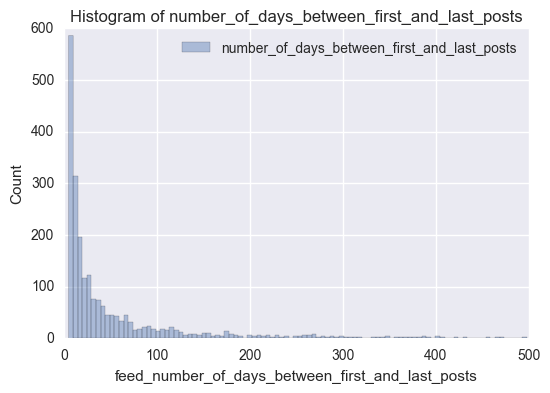

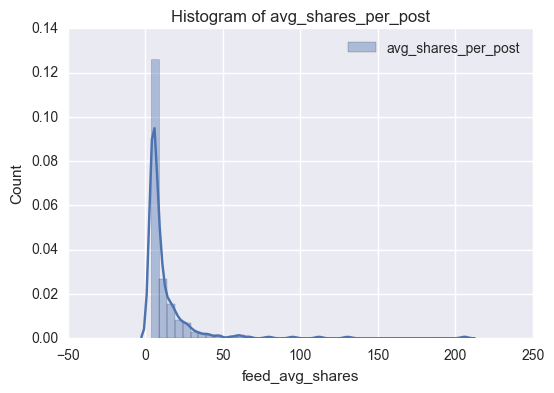

In [22]:
feed_numric_features = {'avg_likes_per_post':{'column': 'feed_avg_likes','lower_bound': 5, 'upper_bound': 800, 'bins': 40, 'kde': True},
                        'avg_comments_per_post': {'column': 'feed_avg_comments','lower_bound': 5, 'upper_bound': 100, 'bins': 30, 'kde': True},
                        'avg_shares_per_post': {'column': 'feed_avg_shares','lower_bound': 4, 'upper_bound': 400, 'bins': 40, 'kde': True},
                        'number_of_days_between_first_and_last_posts': {'column': 'feed_number_of_days_between_first_and_last_posts','lower_bound': 5, 'upper_bound': 500, 'bins': 100, 'kde': False}}

show_numric_features(feed_numric_features)


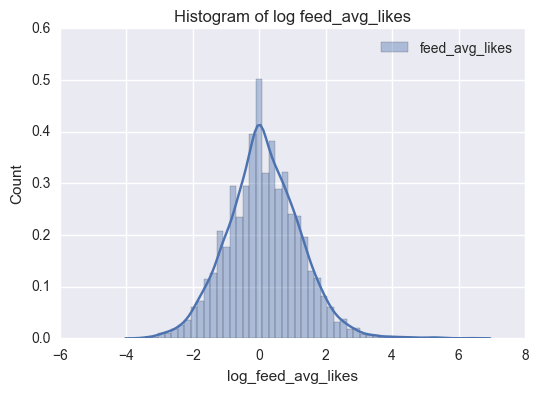

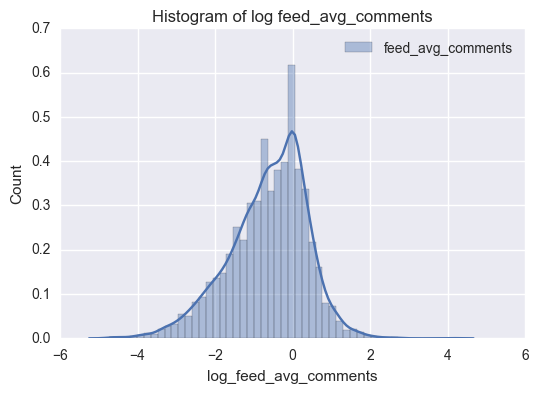

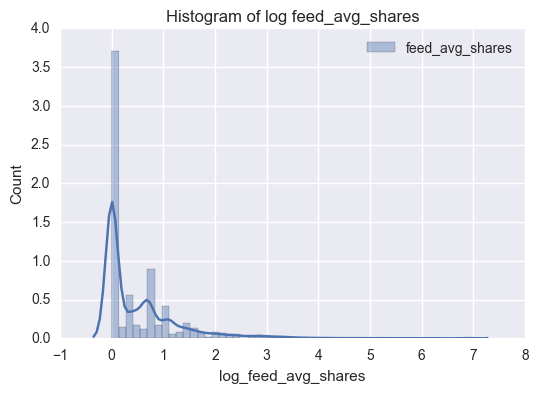

In [23]:
feed_exp_features = ['feed_avg_likes','feed_avg_comments','feed_avg_shares']
show_log_numric_features(feed_exp_features)

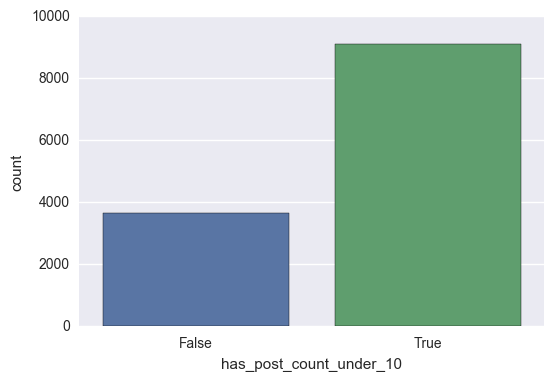

In [24]:
data = [all_data['feed_post_count'].apply(lambda x: True if x < 10 else False).to_frame('has_post_count_under_10')]
show_categorical_data(data)

### Photos features

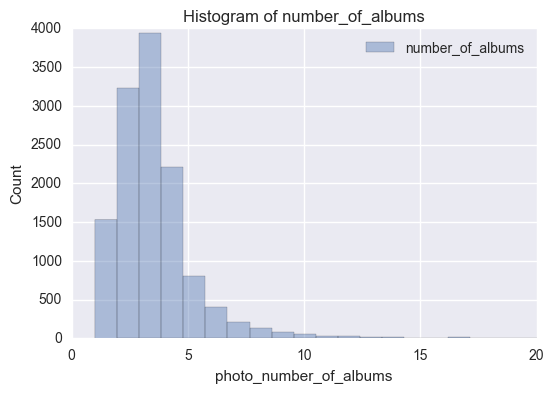

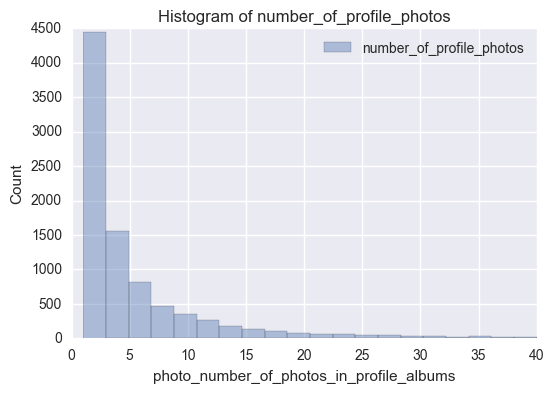

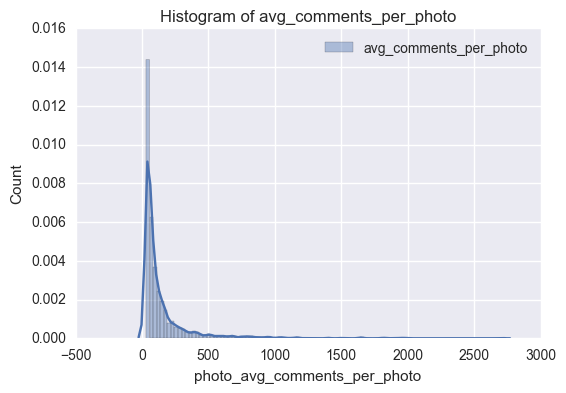

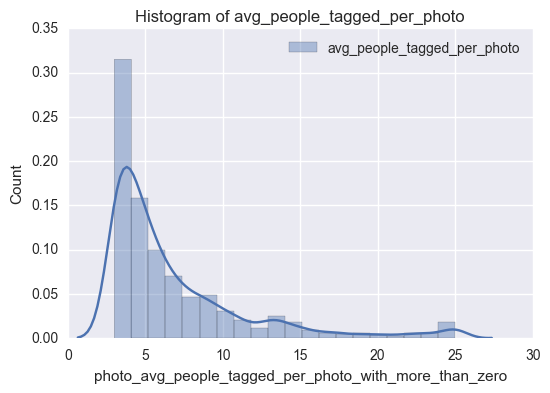

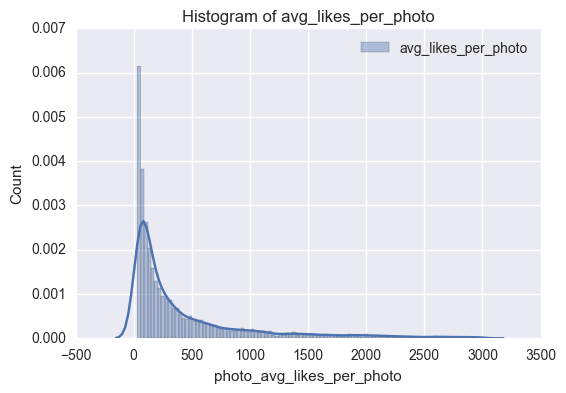

In [25]:
photo_numric_features = {'avg_likes_per_photo':{'column': 'photo_avg_likes_per_photo','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_comments_per_photo':{'column': 'photo_avg_comments_per_photo','lower_bound': 30, 'upper_bound': 3000, 'bins': 100, 'kde': True},
                        'avg_people_tagged_per_photo':{'column': 'photo_avg_people_tagged_per_photo_with_more_than_zero','lower_bound': 3, 'upper_bound': 100, 'bins': 20, 'kde': True},
                        'number_of_albums': {'column': 'photo_number_of_albums','lower_bound': 0, 'upper_bound': 20, 'bins': 20, 'kde': False},
                        'number_of_profile_photos': {'column':'photo_number_of_photos_in_profile_albums', 'lower_bound': 1, 'upper_bound': 40, 'bins': 20, 'kde': False}}

show_numric_features(photo_numric_features)

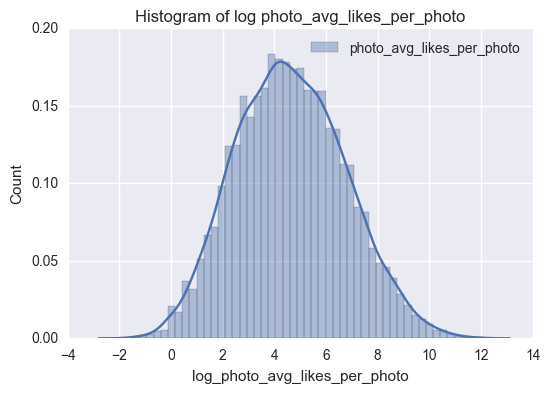

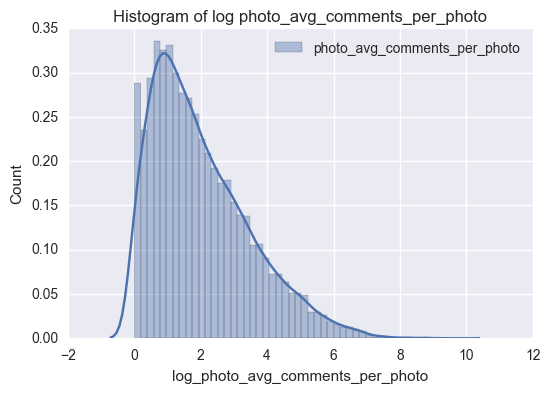

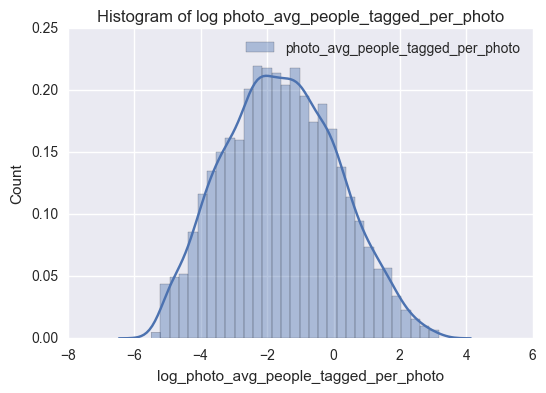

In [26]:
photo_exp_features = ['photo_avg_likes_per_photo', 'photo_avg_comments_per_photo',  'photo_avg_people_tagged_per_photo']
show_log_numric_features(photo_exp_features)

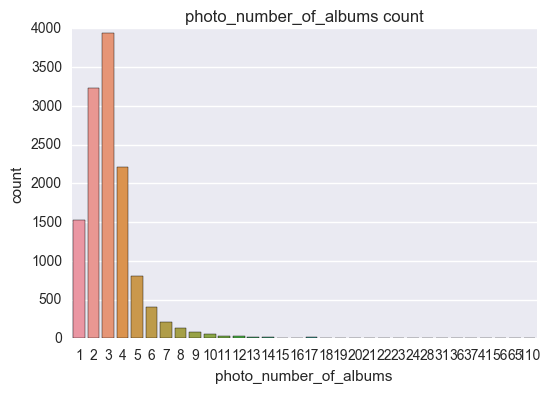

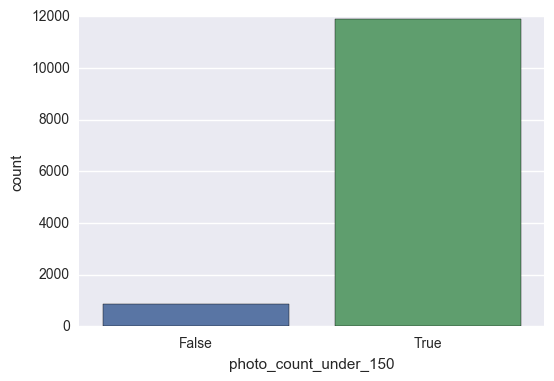

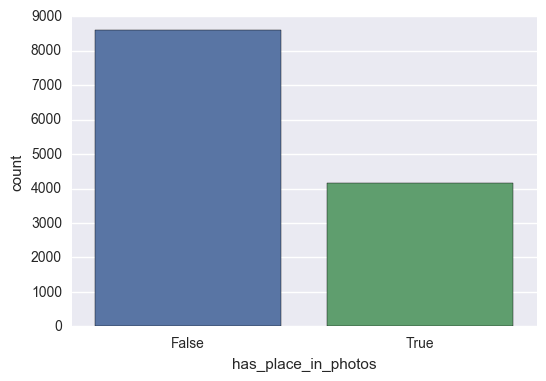

In [27]:
page_categorical_features = ['photo_number_of_albums'] #TODO: add upper bound / move to numrical

show_categorical_features(page_categorical_features)

feat = 'photo_count_under_150'
data = [all_data['total_photos'].apply(lambda x: True if x < 150 else False).to_frame('photo_count_under_150'),
       all_data['photo_count_has_place'].apply(lambda x: True if x > 0 else False).to_frame('has_place_in_photos')]

show_categorical_data(data)
# show_categorical_data(feat, data_to_show)

## Correlations

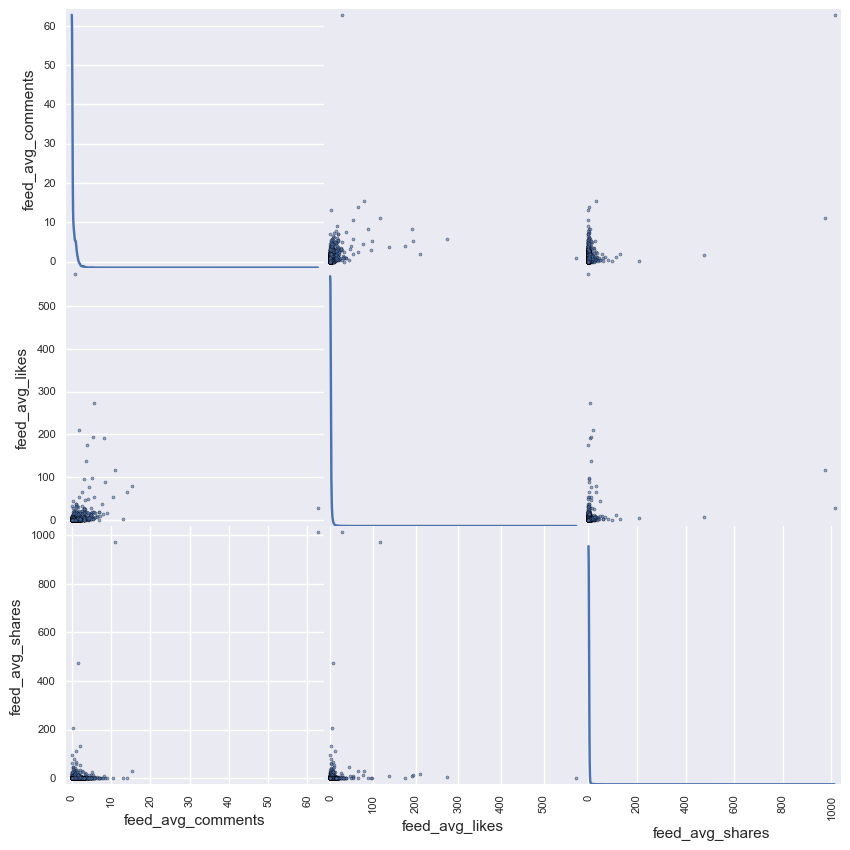

,feed_avg_comments,feed_avg_likes,feed_avg_shares
feed_avg_comments,1.00,0.27,0.51
feed_avg_likes,0.27,1.00,0.14
feed_avg_shares,0.51,0.14,1.00


In [28]:
interaction_variables = ['likes', 'talking_about_count', 'were_here_count'] #'fanCount', 
photo_tags =['photo_avg_people_tagged_per_photo', 'photo_avg_people_tagged_per_photo_with_more_than_zero']
feed_tags = ['feed_avg_with_tagged_per_post', 'feed_avg_people_tagged_per_post']
photo_likes = ['photo_max_like', 'photo_min_like', 'photo_avg_likes_per_photo']
feed_interactions = ['feed_avg_comments', 'feed_avg_likes', 'feed_avg_shares']
feed_categories = ['feed_number_of_added_photos_category','feed_number_of_different_months_for_post',
                   'feed_number_of_null_category', 'feed_number_of_other_categories','feed_number_of_shared_story_category']

show_correlation(feed_interactions)
all_data[feed_interactions].corr()
# show_correlation(photo_likes)
# all_data[feed_tags].corr()

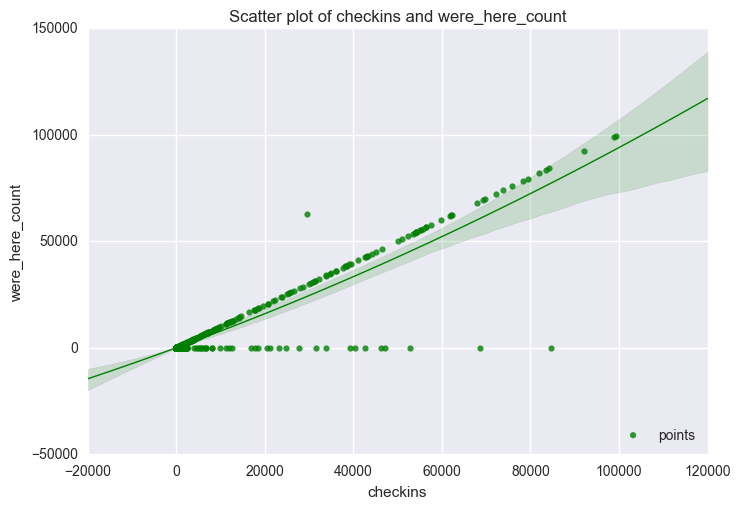

,checkins,were_here_count
checkins,1.00,0.48
were_here_count,0.48,1.00


In [29]:
data_to_show = {'checkins':(0,100000), 'were_here_count':(0,100000)} 
show_scatter(data_to_show)

all_data[data_to_show.keys()].corr()

## Likes analysis

count        12,764.00
mean        429,905.08
std       2,216,464.40
min               0.00
25%           9,192.25
50%          38,107.50
75%         172,433.25
max     102,762,547.00
Name: likes, dtype: float64


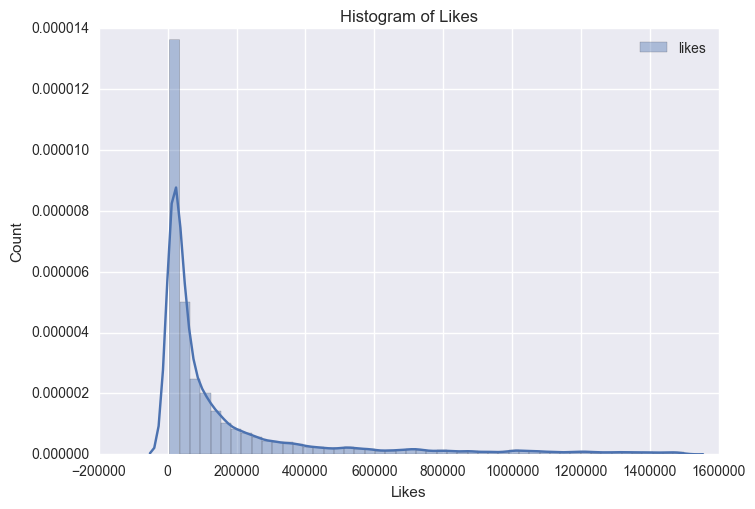

count   12,756.00
mean        10.60
std          2.26
min          0.00
25%          9.13
50%         10.55
75%         12.06
max         18.45
Name: likes, dtype: float64


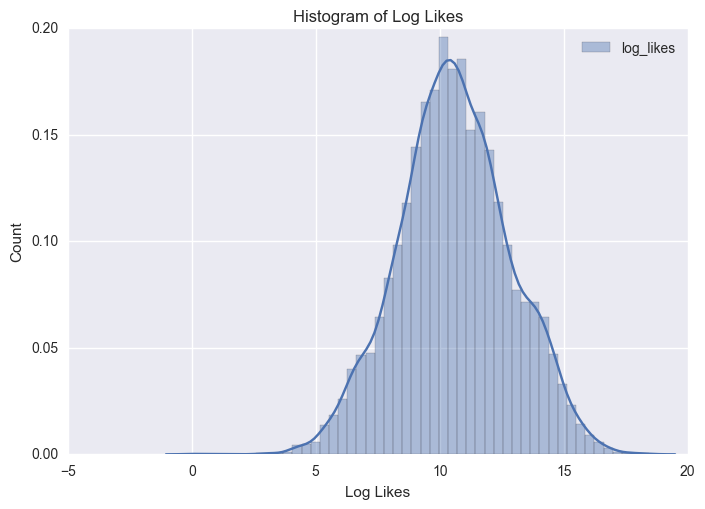

skewness: -0.00136172485706
kurtosis: -0.0225753909844 



In [30]:
print all_data.likes.describe()
sns.distplot(all_data[(all_data['likes'] > 5000) & (all_data['likes'] < 1500000)].likes, 
             bins = 50, kde = True, label = "likes")
plt.title('Histogram of Likes')
plt.xlabel('Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

log_likes = all_data[all_data['likes'] > 0]['likes'].apply(lambda x: np.log(x))
print log_likes.describe()

sns.distplot(log_likes, bins = 50, kde = True, label = "log_likes")
plt.title('Histogram of Log Likes')
plt.xlabel('Log Likes')
plt.ylabel('Count')
plt.legend(loc="upper right")
plt.show()

print "skewness:", log_likes.skew()
print "kurtosis:", log_likes.kurtosis(), '\n'


In [31]:
features = get_features_to_analyze()
corr_features = ['likes'] + get_features_to_analyze()

pearson_corrs = all_data[corr_features].corr(method="pearson")['likes'].sort_values(ascending=False)
spearman_corrs = all_data[corr_features].corr(method="spearman")['likes'].sort_values(ascending=False)

print "top correlation to likes using pearson estimator:"
print "================================================="
print pearson_corrs[1:11]

print "\ntop correlation to likes using spearman estimator:"
print "=================================================="
print spearman_corrs[1:11]

top correlation to likes using pearson estimator:
self_feed_avg_likes            0.52
photo_max_like                 0.51
photo_avg_likes_per_photo      0.50
self_feed_std_likes            0.46
self_feed_max_likes            0.42
photo_avg_comments_per_photo   0.36
talking_about_count            0.29
is_verified                    0.29
were_here_count                0.28
self_feed_max_comments         0.27
Name: likes, dtype: float64

top correlation to likes using spearman estimator:
talking_about_count         0.76
self_feed_avg_likes         0.71
photo_max_like              0.69
self_feed_max_likes         0.68
self_feed_std_likes         0.68
photo_avg_likes_per_photo   0.67
self_feed_avg_comments      0.66
total_photos                0.65
self_feed_max_comments      0.64
self_feed_std_comments      0.64
Name: likes, dtype: float64


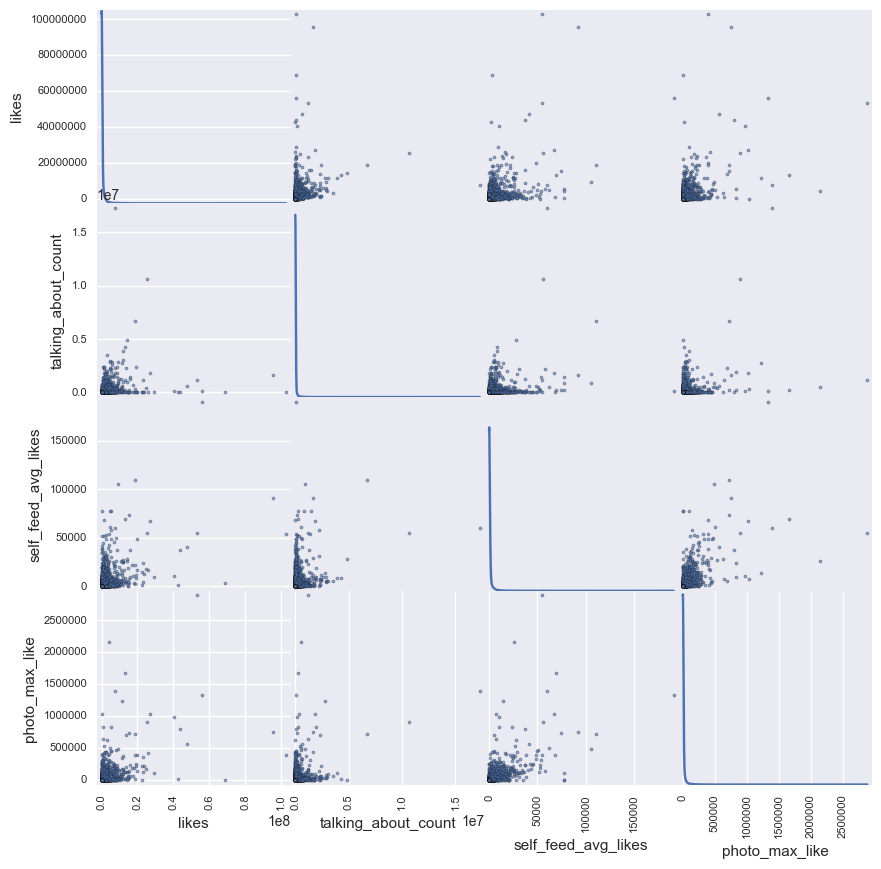

,likes,talking_about_count,self_feed_avg_likes,photo_max_like
likes,1.00,0.29,0.52,0.51
talking_about_count,0.29,1.00,0.35,0.37
self_feed_avg_likes,0.52,0.35,1.00,0.63
photo_max_like,0.51,0.37,0.63,1.00


In [32]:
corr_features = ['likes'] + [a for a in spearman_corrs.index.values[1:4]]
show_correlation(corr_features)
all_data[corr_features].corr()

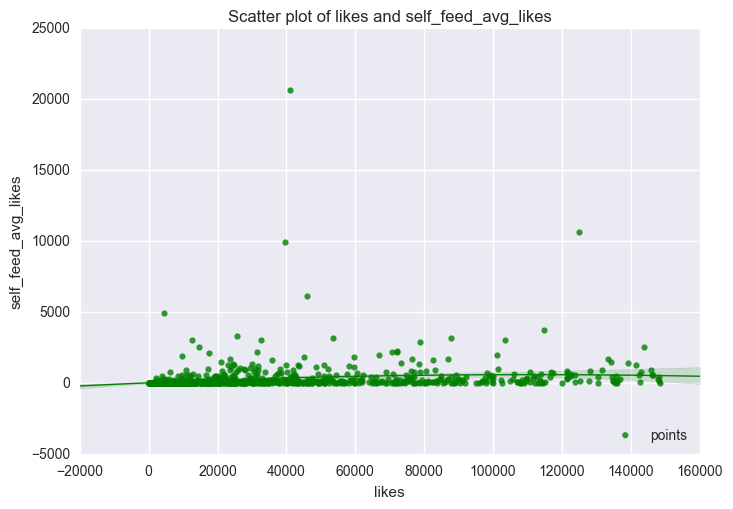

,self_feed_avg_likes,likes
self_feed_avg_likes,1.00,0.52
likes,0.52,1.00


In [33]:
data_to_show = {'self_feed_avg_likes':(0,np.inf), 'likes':(0,150000)} 
show_scatter(data_to_show,op=1)
all_data[data_to_show.keys()].corr()

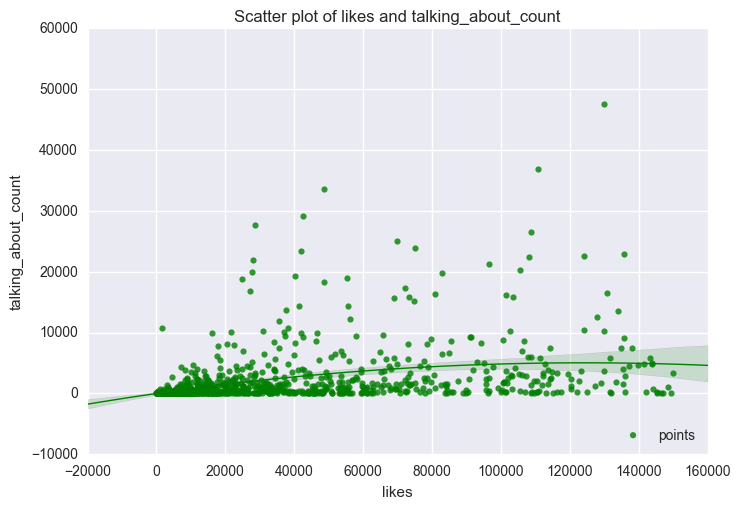

,talking_about_count,likes
talking_about_count,1.00,0.29
likes,0.29,1.00


In [34]:
data_to_show = {'talking_about_count':(1,100000), 'likes':(0,150000)} 
show_scatter(data_to_show,op=1)
all_data[data_to_show.keys()].corr()

In [35]:
avg_likes_per_category = all_data.groupby(['search_category'], as_index=False).mean()[['search_category','likes']].sort_values('likes', ascending=False)
avg_likes_per_category.rename(columns={'likes':'avg_likes'}, inplace=True)
avg_likes_per_category.head(5)

,search_category,avg_likes
19,Movie,"1,618,208.58"
13,Foo,"1,575,577.71"
29,TV,"1,290,613.54"
1,Bar,"1,284,507.66"
3,Beverages,"1,274,734.64"


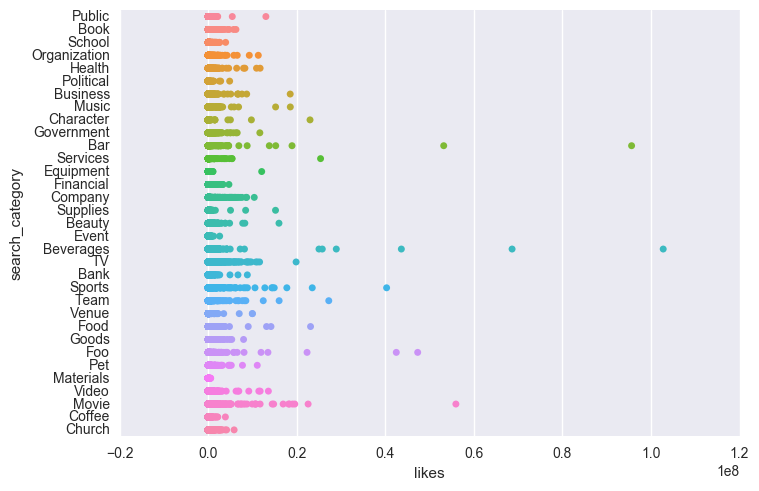

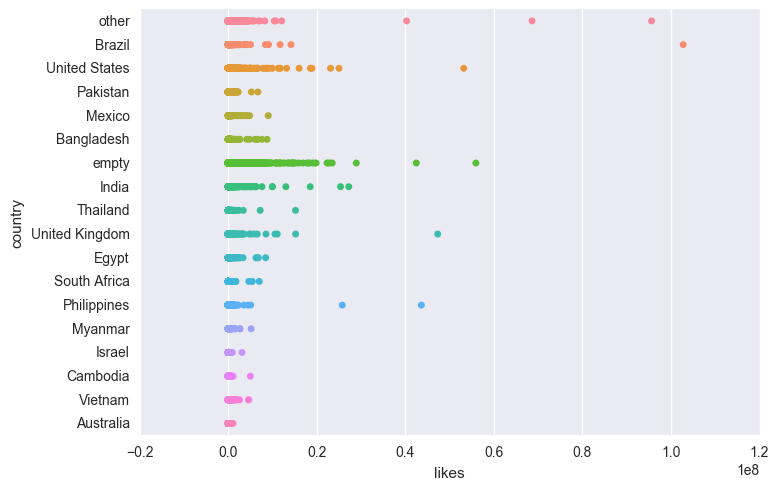

In [36]:
sns.stripplot(x="likes", y="search_category", data=all_data)
plt.show()
sns.stripplot(x="likes", y="country", data=all_data)
plt.show()

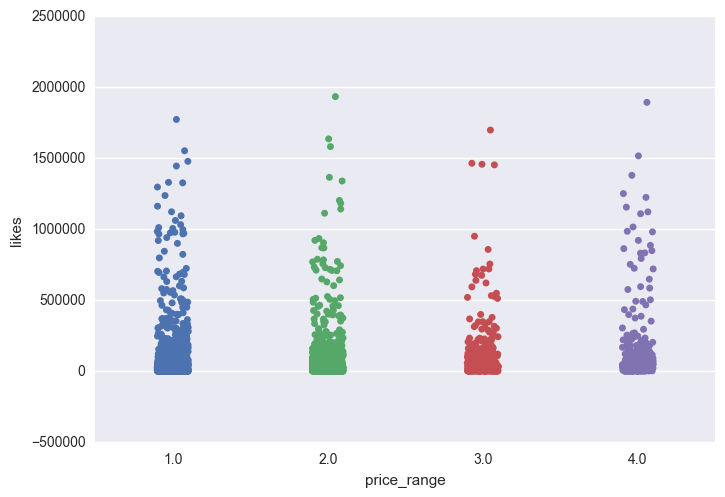

In [37]:
data_to_show = all_data[(all_data['likes'] > 0) & (all_data['likes'] < 2000000)]
price_data = data_to_show[(data_to_show['price_range'] > 0)]
sns.stripplot(x="price_range", y="likes", data=price_data, jitter=True)
plt.show()

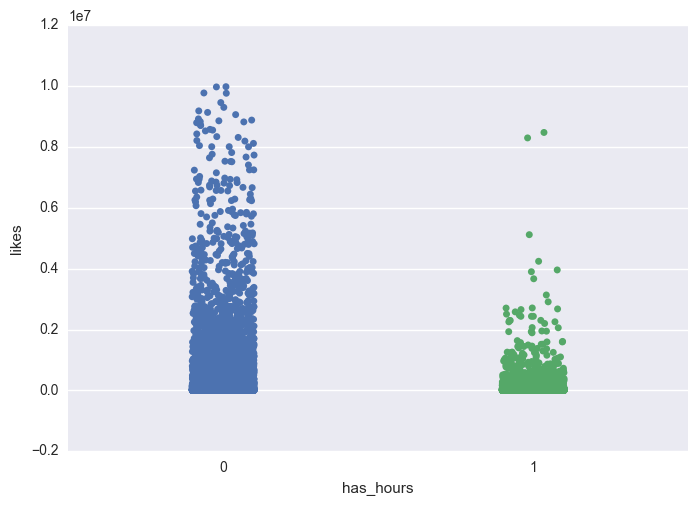

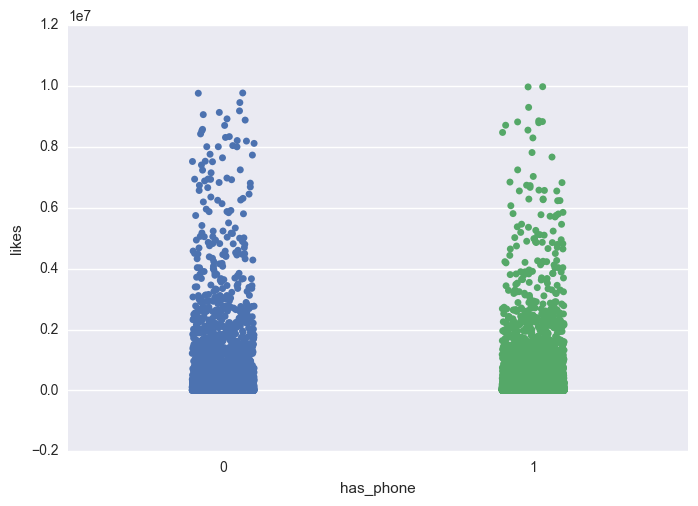

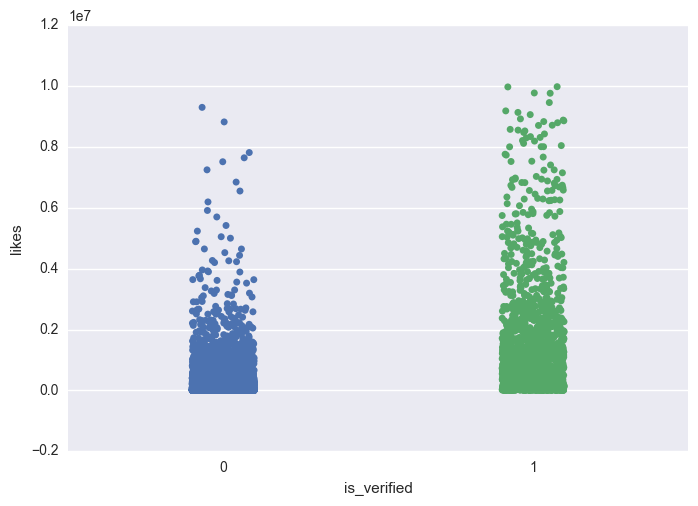

In [38]:
data_to_show = all_data[(all_data['likes'] > 0) & (all_data['likes'] < 10000000)]

sns.stripplot(x="has_hours", y="likes", data=data_to_show, jitter=True)
plt.show()
sns.stripplot(x="has_phone", y="likes", data=data_to_show, jitter=True)
plt.show()
sns.stripplot(x="is_verified", y="likes", data=data_to_show, jitter=True)
plt.show()

# sns.stripplot(x="has_hours", y="likes", data=data_to_show, hue="has_phone", jitter=True)
# plt.show()

## Manual data normalization

In [39]:
normal_by_total_count_vars = [  ['photo_number_of_cover_albums', 'photo_number_of_albums'],
                                ['photo_number_of_other_albums', 'photo_number_of_albums'],
                                ['photo_number_of_profile_albums', 'photo_number_of_albums'],
                                ['photo_number_of_photos_in_cover_albums', 'total_photos'],
                                ['photo_number_of_photos_in_profile_albums', 'total_photos'],
                                ['photo_count_has_name', 'total_photos'],
                                ['photo_count_has_place', 'total_photos'],
                                ['feed_count_has_place', 'feed_post_count'],
                                ['feed_count_post_updated', 'feed_post_count'],
                                ['feed_number_of_added_photos_category', 'feed_post_count'],
                                ['feed_number_of_different_months_for_post', 'feed_post_count'],
                                ['feed_number_of_other_categories', 'feed_post_count'],
                                ['feed_number_of_shared_story_category', 'feed_post_count'],
                                ['self_feed_count_has_place', 'self_post_count'],
                                ['self_feed_count_post_updated', 'self_post_count'],
                                ['self_feed_number_of_added_photos_category', 'self_post_count'],
                                ['self_feed_number_of_different_months_for_post', 'self_post_count'],
                                ['self_feed_number_of_null_category', 'self_post_count'],
                                ['self_feed_number_of_other_categories', 'self_post_count'],
                                ['self_feed_number_of_shared_story_category', 'self_post_count']
                             ]

for feat in normal_by_total_count_vars: 
    all_data[feat[0]] = all_data.apply(lambda x: (x[feat[0]] / x[feat[1]]) if (x[feat[1]] != 0) else 0, axis=1)
    
# originally the api calls to facebook were supposed to get the first 150 photos/feed posts of a page.
# along the way we got a little more in some cases, so after normalization of the relevant features by this count, 
# we lower them to 150 to prevent bias..
all_data['total_photos'] = all_data['total_photos'].apply(lambda x: x if x <= 150 else 150)
all_data['feed_post_count'] = all_data['feed_post_count'].apply(lambda x: x if x <= 150 else 150)
all_data['self_post_count'] = all_data['self_post_count'].apply(lambda x: x if x <= 150 else 150)

# Models

## Utils

In [40]:
def binning(col,bin_num, labels=None):
    if labels is None:
        labels = ['BIN_'+str(i) for i in range(bin_num)]

    colBin = pd.qcut(col,bin_num,labels=labels)
    return colBin

def plot_results(x, y, tag, arg):
    plt.plot(x, y)
    plt.title(tag + " as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel(tag)
    plt.show()

def plot_cross_val(cs, cv_scores, arg):
    plt.plot(cs, cv_scores)
    plt.title("Average Precision as a function of " + arg)
    plt.xlabel(arg)
    plt.ylabel("Precision")
    ax = plt.axes()
    ax.set_xscale('log')
    plt.show()

def plotRoc(fpr, tpr, auc):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def plotPR(precision, recall):
    plt.figure()
    plt.plot(recall, precision, label='PR curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall curve')
    plt.legend(loc='lower left')
    plt.show()

def plotMetrics(expected,predicted):
    y_true = expected
    y_score = predicted
    #y_score = df['rawPrediction'].map(lambda x: x['values'][1])
    auc = sklearn.metrics.roc_auc_score(y_true, y_score)
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_true, y_score)
    plotRoc(fpr, tpr, auc)
    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_true, y_score, pos_label=1)
    plotPR(precision, recall)

def plotConfusion(matrix, n, model_name=''):
    plt.title(model_name + ' Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.imshow(np.reshape(matrix, (n, n)), interpolation='nearest', cmap="hot")
    plt.colorbar()
    plt.show()
        
def _log(x):
    if x > 0:
        return np.log(x)
    return x  

def remove_outliers(ds, feat, stdv_cut):
    if feat == 'likes':
        ds['log_' + feat] = ds[feat].apply(_log)
        ds = ds[abs(ds['log_' + feat] - ds['log_' + feat].mean()) <= stdv_cut*ds['log_' + feat].std()]
        ds.drop('log_' + feat, 1, inplace=True)
    else:
        ds = ds[abs(ds[feat] - ds[feat].mean()) <= stdv_cut*ds[feat].std()]
    return ds

def get_feat_sel(train_set, test_set, train_labels, test_labels, model, min_feats=30, verbose=False):
    all_feats = train_set.columns.values.tolist()
    numerical_feats = [feat for feat in all_feats if set(train_set[feat].unique()) != {-1,1} and feat not in ['id']]

    # feature selection
    results = []
    feats_num = train_set.shape[1]
    threshold = 0.0000001
    while feats_num > min_feats:
        model.fit(train_set, train_labels)
        sfm = SelectFromModel(model, prefit=True, threshold=threshold)
        if len(sfm.get_support(indices=True)) == feats_num:
            threshold = threshold*10
        else:
            feats_num = len(sfm.get_support(indices=True))
            threshold = threshold*1.5

        if feats_num <= train_set.shape[1] * 0.8:
            if verbose: print "get_data_sets: found threshold %s that selected %s feats" % (threshold, feats_num)

            feats_idx_list = list(sfm.get_support(indices=True))
            # re-fit model to score new data set
            new_train_set = sfm.transform(train_set)
            new_test_set = sfm.transform(test_set)
            model.fit(new_train_set, train_labels)

            result = {
                'feats_num': feats_num,
                'threshold': threshold,
                'selected_idx': feats_idx_list,
                'selected_feats': [all_feats[i] for i in feats_idx_list],
                'test_score': model.score(new_test_set, test_labels),
                'train_score': model.score(new_train_set, train_labels),
            }
            results.append(result)
    
    return sorted(results, key=lambda x: x['test_score'], reverse=True)

def bins_to_binary(labels, sel_bin, is_1_vs_all=False):
    if is_1_vs_all:
        result = labels.apply(lambda x: x == sel_bin)
    else:
        result = labels.apply(lambda x: int(x[-1]) <= int(sel_bin[-1]))
    return result

def calculate_confusion_matrix_score(matrix, num_bins_away):
    d=len(matrix)
    precisions = []
    recalls = []
    f1_scores = []
    for i in range(d):
        row_precision = 0
        for j in range(i-num_bins_away,i+num_bins_away+1):
            if j>=0 and j<d:
                row_precision+=matrix[i][j]
        precision_float = float(row_precision)/sum(matrix[i])
        recall_float = float(row_precision)/sum([row[i] for row in matrix])
        
        precisions.append(precision_float) 
        recalls.append(recall_float) 
        f1_scores.append(2 * (precision_float * recall_float) / (precision_float + recall_float))
    
    avg_precisions = np.mean(precisions)
    avg_recalls = np.mean(recalls)
    avg_f1_score = np.mean(f1_scores)

    return avg_precisions, avg_recalls, avg_f1_score

def eval_model(model_name, labels, predictions, predicted_probs, is_val=False, bin_num=8):
    data_type = "validation" if is_val else "train"
    print str.upper("%s %s results" % (model_name, data_type))
    print "=========" + "=" * len(model_name + data_type)
    
    print "\nClassification report:"
    print metrics.classification_report(labels, predictions)
    
    if (bin_num == 2):
        plotMetrics(labels,predicted_probs)
        fpr, tpr, thresholds = metrics.roc_curve(labels, predicted_probs)
        auc = metrics.auc(fpr, tpr)
        print "%s %s set auc: %s" % (model_name, data_type, auc)
        plotRoc(fpr, tpr, auc)
    
    print "\nConfusion matrix with %s bins: " % bin_num
    cm = confusion_matrix(labels.values, predictions)
    print cm
    plotConfusion(cm, bin_num, model_name)

    final_score = metrics.f1_score(labels, predictions, average='micro')
    print "\n%s %s f1-score:%s" % (model_name, data_type, final_score)
    if bin_num == 8:
        precision, recall, f1_score = calculate_confusion_matrix_score(cm, 1)
        print '\n=================='
        print '1-Bin-Away scores:'
        print '=================='
        print 'Avg Precision: %s\nAvg Recall: %s\nAvg f1-score: %s' % (precision, recall, f1_score)
    
    return final_score

    
def grubbs_outlier_removal(data_set, feats, verbose=False):
    ds = data_set.copy()
    total_diff = 0
    
    if verbose: print "\ngrubbs_outlier_removal: Got %s feats to remove outliers by. STARTING...\n" % len(feats)
    for feat in feats:
        temp = ds.shape[0]
        alpha = 0.05
        idxs = grubbs.two_sided_test_indices(ds[feat], alpha=alpha)
        while len(idxs) > 100:
            if alpha < 0.02:
                # feature distribution is probably not normal, skip
                idxs = []
                break
            alpha = alpha / 2
            idxs = grubbs.two_sided_test_indices(ds[feat], alpha=alpha)
        ds.drop(ds.index[idxs], inplace=True)
        if len(idxs) > 0 and verbose: print "grubbs_outlier_removal: feat %s - %s samples removed, %s samples left" % (feat, len(idxs), ds.shape[0])
        total_diff += temp - ds.shape[0]

    if verbose: print "grubbs_outlier_removal: Total of %s samples removed, %s samples left" % (total_diff, ds.shape[0])
    return ds


## General Preprocessing

### dummies variables 

In [41]:
# change back empty and 0 to NaN before converting to dummy variables
categorical_variables = ['country', 'price_range', 'main_category', 'search_category', 'category', 'continent']
filtered_all_data = all_data.copy()
# country_dv = pd.get_dummies(filtered_all_data['country'].apply(lambda x: x if x != 'empty' else np.nan), prefix='country')
price_dv = pd.get_dummies(filtered_all_data['price_range'].apply(lambda x: x if x > 0 else np.nan), prefix='price_range')
category_dv = pd.get_dummies(filtered_all_data['main_category'], prefix='main_category')
continent_dv = pd.get_dummies(filtered_all_data['continent'], prefix='continent')

print "shape before dummy vars: ", filtered_all_data.shape
pp_data = pd.concat([filtered_all_data, price_dv, category_dv, continent_dv], axis=1)
pp_data.drop(categorical_variables, 1, inplace=True)
print "shape after dummy vars: ", pp_data.shape

shape before dummy vars:  (12764, 103)
shape after dummy vars:  (12764, 113)


### Data Normalization - run log on numerical features and scale

In [42]:
cat_vars = [feat for feat in pp_data.columns.values.tolist() if set(pp_data[feat].unique()) == {0,1}]
pp_data[cat_vars] = pp_data[cat_vars].astype(bool)
for feat in cat_vars:
    pp_data[feat] = pp_data[feat].apply(lambda x: 1 if x else -1)
    
exp_feats = [feat for feat in pp_data.columns.get_values().tolist() if set(pp_data[feat].unique()) != {-1,1} and feat not in ['id', 'name_num_of_words', 'likes', 'labels']]
for feat in exp_feats:
    pp_data[feat] = pp_data[feat].apply(_log)
    max_val = pp_data[feat].max()
    pp_data[feat] = preprocessing.scale(pp_data[feat].apply(lambda x: -max_val if x == 0 else x))
    

### Split data to test and train/validation sets

In [43]:
from sklearn.utils import shuffle

pp_data = shuffle(pp_data)
pp_data['4_bin_labels'] = binning(pp_data['likes'], 4)
pp_data['8_bin_labels'] = binning(pp_data['likes'], 8)

test_data_len = int(pp_data.shape[0] * 0.1)
test_pp_data = pp_data[:test_data_len]

test_data_ids = test_pp_data['id'].copy()
test_data_labels = test_pp_data[['likes', '4_bin_labels', '8_bin_labels']].copy()
test_data_set = test_pp_data.drop(['id', 'likes', '4_bin_labels', '8_bin_labels'], axis=1)

pp_data = pp_data[test_data_len:]

### Initial outlier removal

In [44]:
temp = pp_data.shape[0]
pp_data = pp_data[pp_data['likes'] > 0]
pp_data = remove_outliers(pp_data, 'likes', 2)

print "Initial data removal (2*stdv) - %s samples removed, %s samples left" % (temp - pp_data.shape[0], pp_data.shape[0])

Initial data removal (2*stdv) - 510 samples removed, 10978 samples left


/Users/guysalama/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [45]:
pp_data[pp_data['likes'] < 10]['likes']

Series([], Name: likes, dtype: int64)

### Split data set to train and validation data

In [46]:
train_len = int(pp_data.shape[0] * 0.8)

train_ids = pp_data['id'][:train_len].copy()
val_ids = pp_data['id'][train_len:].copy()

train_labels = pp_data[['likes', '4_bin_labels', '8_bin_labels']][:train_len].copy()
val_labels = pp_data[['likes', '4_bin_labels', '8_bin_labels']][train_len:].copy()

temp_pp_data = pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
train_set = temp_pp_data[:train_len].copy()
val_set = temp_pp_data[train_len:].copy()

print "4-Bin Details:"
print pp_data.groupby('4_bin_labels')['likes'].describe()
print "8-Bin Details:"
print pp_data.groupby('8_bin_labels')['likes'].describe()

4-Bin Details:
4_bin_labels       
BIN_0         count       2,595.00
              mean        3,960.87
              std         2,561.10
              min           447.00
              25%         1,671.00
              50%         3,504.00
              75%         6,005.50
              max         9,187.00
BIN_1         count       2,849.00
              mean       20,764.48
              std         8,240.38
              min         9,194.00
              25%        13,403.00
              50%        19,553.00
              75%        27,483.00
              max        38,101.00
BIN_2         count       2,866.00
              mean       86,469.92
              std        37,921.84
              min        38,114.00
              25%        53,188.00
              50%        77,280.00
              75%       114,030.50
              max       172,395.00
BIN_3         count       2,668.00
              mean      851,923.30
              std       777,552.37
              min   

### Test feature selection on Logistic Regression (sanity)

In [47]:
temp_train_labels = bins_to_binary(train_labels['4_bin_labels'], 'BIN_1') 
temp_val_labels = bins_to_binary(val_labels['4_bin_labels'], 'BIN_1') 

print "Logistic regression feature selection by importance:"
lr = lm.LogisticRegression(penalty='l2', C=0.01) #dual=True)
lr.fit(train_set, temp_train_labels)
print "Train set score (before selection): ", lr.score(train_set, temp_train_labels)
print "Validation set score (before selection): ", lr.score(val_set, temp_val_labels)

sfm = SelectFromModel(lr, prefit=True)

selected_feats = sfm.get_support(indices=True)
print "total of %s out of %s feats left:" % (len(selected_feats), len(train_set.columns.get_values()))
for feat_idx in selected_feats:
    print "%s\t%s" % (feat_idx, train_set.columns.get_values()[feat_idx])

new_train = sfm.transform(train_set)
new_test = sfm.transform(val_set)
lr.fit(new_train, temp_train_labels)
print "Train set score (after selection): ", lr.score(new_train, temp_train_labels)
print "Validation set score (after selection): ",  lr.score(new_test, temp_val_labels)

Logistic regression feature selection by importance:
Train set score (before selection):  0.842063311319
Validation set score (before selection):  0.822859744991
total of 39 out of 111 feats left:
3	has_company_overview
4	has_about
5	has_hours
6	checkins
7	has_payment_options
11	photo_avg_likes_per_photo
16	photo_max_like
17	photo_max_people_tagged
22	photo_number_of_other_albums
26	total_photos
27	photo_number_of_days_between_first_and_last_photos
36	feed_max_comments
45	feed_post_max_with_tagged
47	feed_std_likes
51	feed_post_count
52	self_feed_avg_comments
53	self_feed_avg_likes
57	self_feed_number_of_days_between_first_and_last_posts
60	self_feed_count_post_updated
64	self_feed_min_likes
69	self_feed_number_of_shared_story_category
72	self_feed_post_updated_prc
74	self_feed_std_likes
77	self_feed_min_shares
80	is_verified
81	talking_about_count
82	were_here_count
84	has_phone
85	has_website
86	has_location
89	has_products
92	photo_upload_freq
94	posting_freq
96	price_range_2.0
102	

## Logistic Regression - Binary model

#### Get binary predictions from LR to be used as features for the multi class models

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   18.9s finished


Best estimator found by grid search:
LogisticRegression(C=0.21544346900318845, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
training logistic regression
getting logistic regression predictions (bin num 0)
LR BINARY PREDICTION - BIN_0: VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      False       0.90      0.94      0.92      1700
       True       0.75      0.62      0.68       496

avg / total       0.86      0.87      0.86      2196



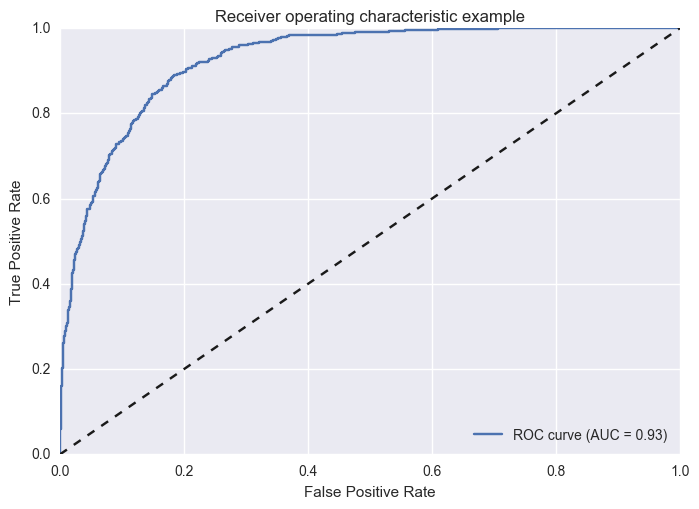

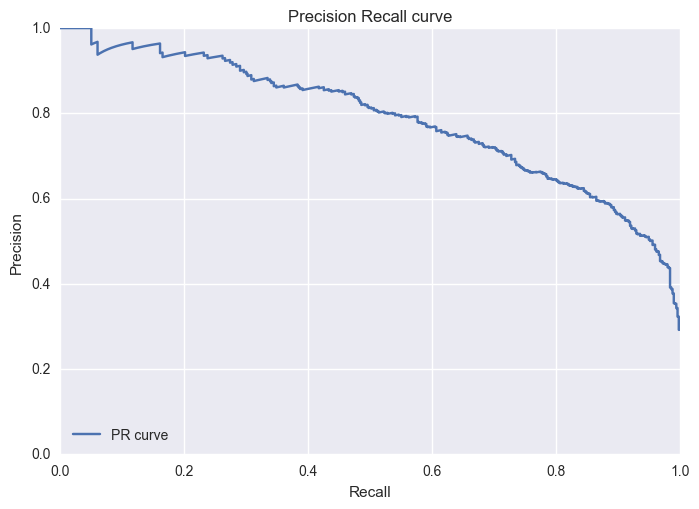

LR binary prediction - BIN_0: validation set auc: 0.926437381404


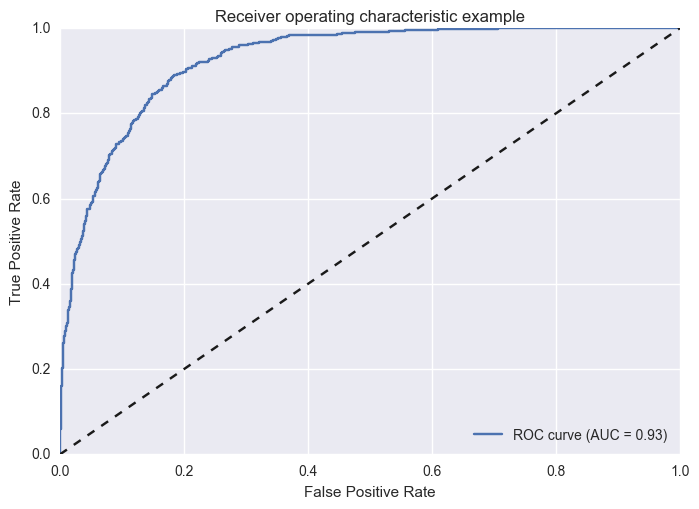


Confusion matrix with 2 bins: 
[[1598  102]
 [ 186  310]]


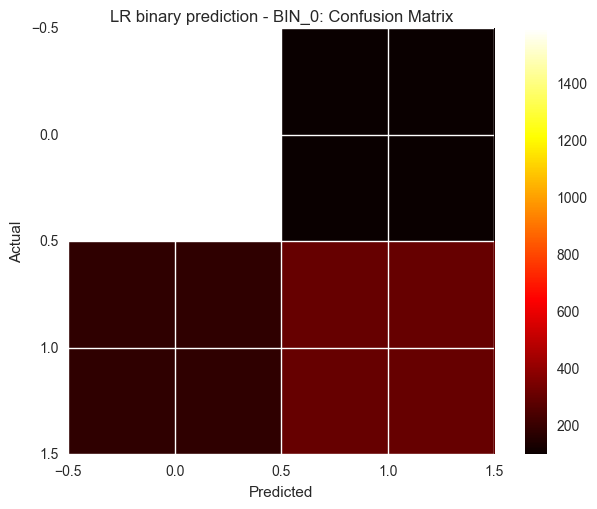


LR binary prediction - BIN_0: validation f1-score:0.868852459016
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   19.6s finished


Best estimator found by grid search:
LogisticRegression(C=46.415888336127821, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
training logistic regression
getting logistic regression predictions (bin num 1)
LR BINARY PREDICTION - BIN_1: VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      False       0.84      0.84      0.84      1124
       True       0.83      0.83      0.83      1072

avg / total       0.83      0.83      0.83      2196



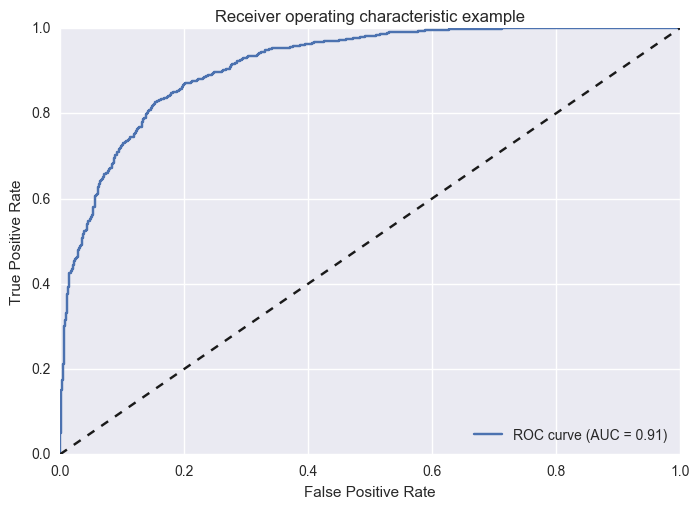

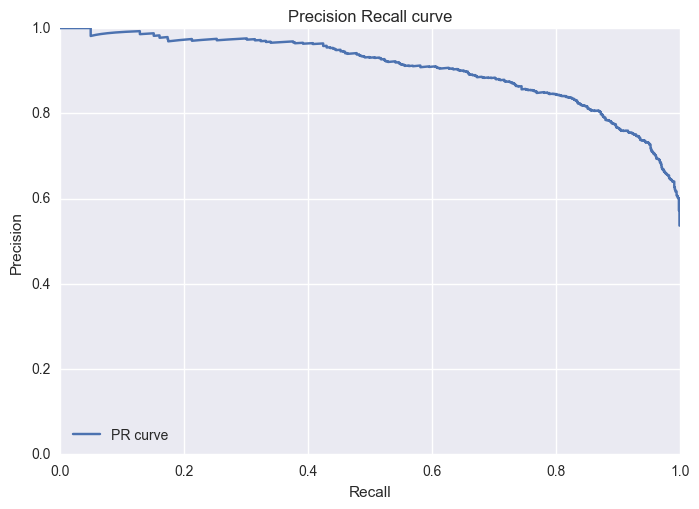

LR binary prediction - BIN_1: validation set auc: 0.914448830138


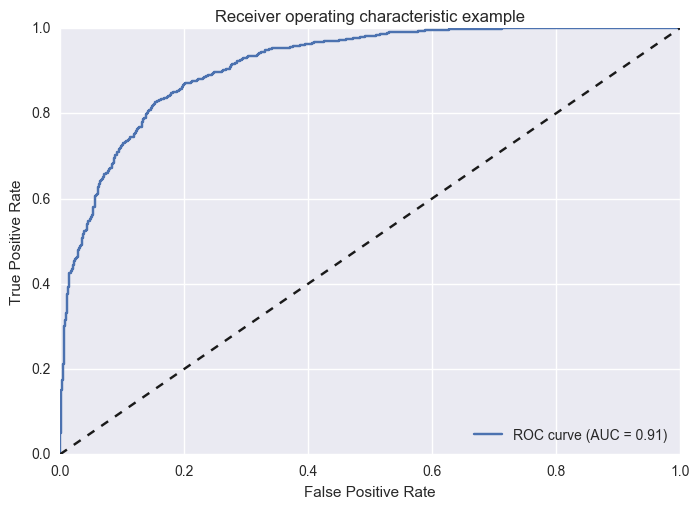


Confusion matrix with 2 bins: 
[[939 185]
 [178 894]]


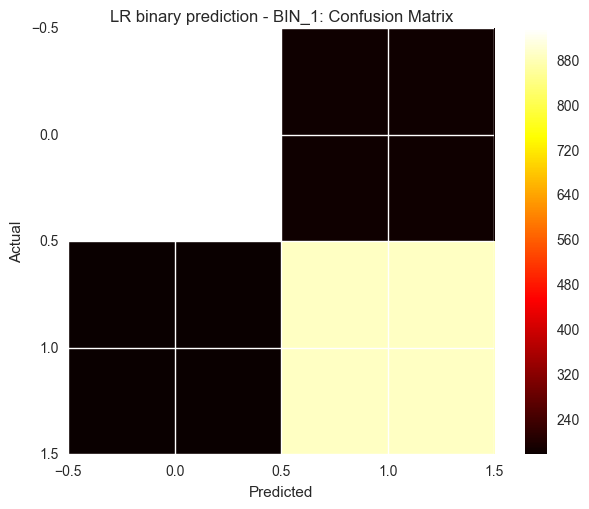


LR binary prediction - BIN_1: validation f1-score:0.834699453552
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   15.2s finished


Best estimator found by grid search:
LogisticRegression(C=0.0059948425031894088, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
training logistic regression
getting logistic regression predictions (bin num 2)
LR BINARY PREDICTION - BIN_2: VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      False       0.83      0.68      0.75       556
       True       0.90      0.95      0.92      1640

avg / total       0.88      0.88      0.88      2196



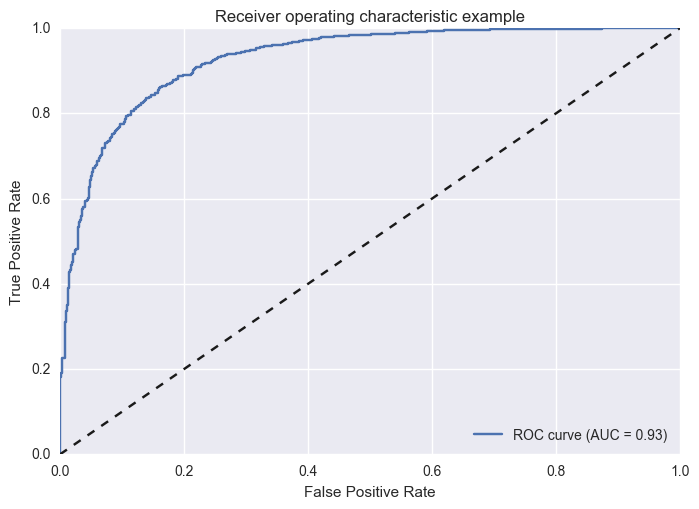

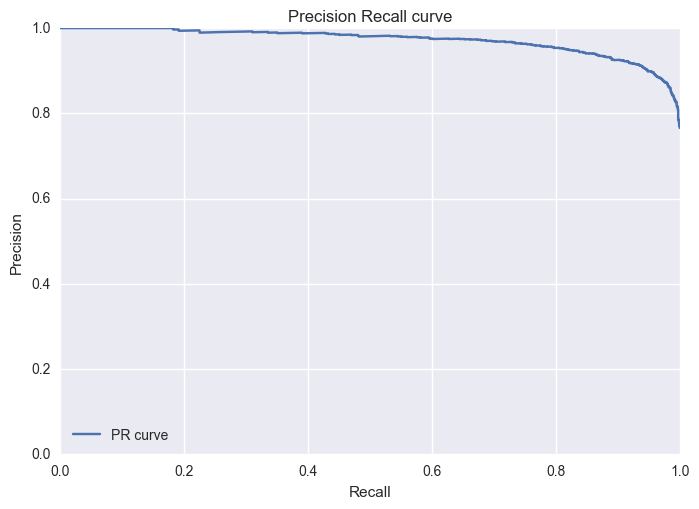

LR binary prediction - BIN_2: validation set auc: 0.927470828215


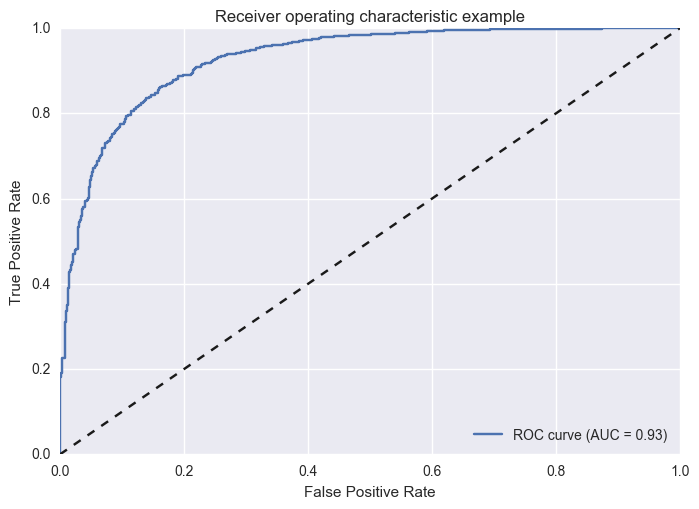


Confusion matrix with 2 bins: 
[[ 380  176]
 [  80 1560]]


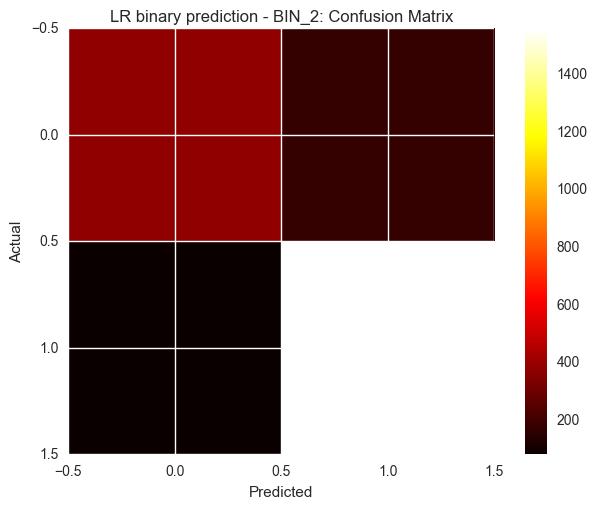


LR binary prediction - BIN_2: validation f1-score:0.883424408015


In [48]:
predictions_ds = pp_data['id'].copy()
test_predictions_ds = test_pp_data['id'].copy()

lr_train_set = train_set.copy()
lr_val_set = val_set.copy()

for seperator in range(3):
    lr_train_labels = bins_to_binary(train_labels['4_bin_labels'], 'BIN_%s' % seperator)
    lr_val_labels = bins_to_binary(val_labels['4_bin_labels'], 'BIN_%s' % seperator)
    
    param_grid = {'C': np.logspace(-3, 4, num=10)}
    clf = GridSearchCV(lm.LogisticRegression(), param_grid, verbose=True)
    clf = clf.fit(lr_train_set, lr_train_labels)
    print("Best estimator found by grid search:")
    print(clf.best_estimator_)

    print "training logistic regression"
    lr = clf.best_estimator_
    lr.fit(lr_train_set, lr_train_labels)

    print "getting logistic regression predictions (bin num %s)" % seperator
    lr_predicted_probs = lr.predict_proba(lr_train_set.append(lr_val_set, ignore_index=True))[:, 1]
    lr_predictions = lr.predict(lr_train_set.append(lr_val_set, ignore_index=True))

    lr_train_predicted_probs = lr_predicted_probs[:lr_train_set.shape[0]]
    lr_val_predicted_probs = lr_predicted_probs[lr_train_set.shape[0]:]

    lr_train_predictions = lr_predictions[:lr_train_set.shape[0]]
    lr_val_predictions = lr_predictions[lr_train_set.shape[0]:]
    
    eval_model("LR binary prediction - BIN_%s:" % seperator, lr_val_labels, lr_val_predictions, lr_val_predicted_probs, True, 2)
    
    # attach LR predictions to predictions_ds
    predictions_ds['lr_prediction_proba_%s' % seperator] = preprocessing.minmax_scale(lr_predicted_probs.copy(), feature_range=(-1, 1))
    test_predictions_ds['lr_prediction_proba_%s' % seperator] = preprocessing.minmax_scale(lr.predict_proba(test_data_set)[:, 1], feature_range=(-1, 1))

### Attach new features to data sets

In [49]:
pp_data['lr_predict_0'] = predictions_ds['lr_prediction_proba_0'].copy()
pp_data['lr_predict_1'] = predictions_ds['lr_prediction_proba_1'].copy()
pp_data['lr_predict_2'] = predictions_ds['lr_prediction_proba_2'].copy()

test_pp_data['lr_predict_0'] = test_predictions_ds['lr_prediction_proba_0'].copy()
test_pp_data['lr_predict_1'] = test_predictions_ds['lr_prediction_proba_1'].copy()
test_pp_data['lr_predict_2'] = test_predictions_ds['lr_prediction_proba_2'].copy()

new_feats = ['lr_predict_0', 'lr_predict_1', 'lr_predict_2']
train_set[new_feats] = pp_data[new_feats][:train_len].copy()
val_set[new_feats] = pp_data[new_feats][train_len:].copy()
test_data_set[new_feats] = test_pp_data[new_feats].copy()

## Linear Regression - Numerical prediction

#### Get numerical predictions from Linear Regression to be used as a feature for the multi class models



Mean squared error: 1.03
training variance score: 0.75
test variance score: 0.74


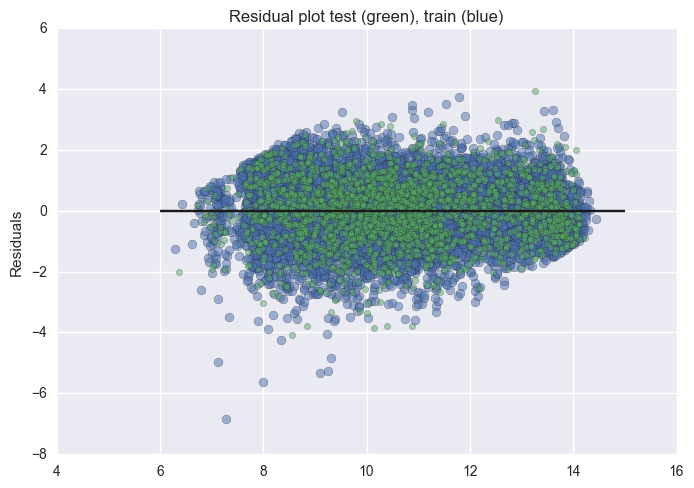

In [50]:
linr_train_set = train_set.copy()
linr_val_set = val_set.copy()

linr_train_labels = train_labels['likes'].apply(_log)
linr_val_labels = val_labels['likes'].apply(_log)

linr = sklearn.linear_model.LinearRegression()
linr.fit(linr_train_set, linr_train_labels)

train_predictions = linr.predict(linr_train_set)
val_predictions = linr.predict(linr_val_set)

predictions_ds['linr_prediction'] = preprocessing.minmax_scale(np.concatenate((train_predictions, val_predictions)), feature_range=(-1, 1))
test_predictions_ds['linr_prediction'] = preprocessing.minmax_scale(linr.predict(test_data_set), feature_range=(-1, 1))

# The mean squared error
print "\n\nMean squared error: %.2f" %(np.mean((linr.predict(linr_train_set) - linr_train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print 'training variance score: %.2f' %(linr.score(linr_train_set, linr_train_labels))
print 'test variance score: %.2f' %(linr.score(linr_val_set, linr_val_labels))
plt.scatter(train_predictions, train_predictions -  linr_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(val_predictions, val_predictions -  linr_val_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=6, xmax=15)
plt.title('Residual plot test (green), train (blue)')
plt.ylabel('Residuals')
plt.show()

### Attach new feature to data sets

In [52]:
pp_data['linr_predict'] = predictions_ds['linr_prediction'].copy()

test_pp_data['linr_predict'] = test_predictions_ds['linr_prediction'].copy()

new_feats = ['linr_predict']
train_set[new_feats] = pp_data[new_feats][:train_len].copy()
val_set[new_feats] = pp_data[new_feats][train_len:].copy()
test_data_set[new_feats] = test_pp_data[new_feats].copy()

## KNN

### Data preparation

In [53]:
knn_train_set = train_set.drop(new_feats, 1)
knn_val_set = val_set.drop(new_feats, 1)

knn_train_labels = train_labels['4_bin_labels'].copy()
knn_val_labels = val_labels['4_bin_labels'].copy()

### Parameter optimization

validation score for k = 2:  0.47723132969
validation score for k = 12:  0.562386156648
validation score for k = 22:  0.561930783242
validation score for k = 32:  0.572859744991
validation score for k = 42:  0.576958105647
validation score for k = 52:  0.563752276867
validation score for k = 62:  0.571038251366
validation score for k = 72:  0.569672131148
validation score for k = 82:  0.575136612022
validation score for k = 92:  0.575136612022
validation score for k = 102:  0.571038251366


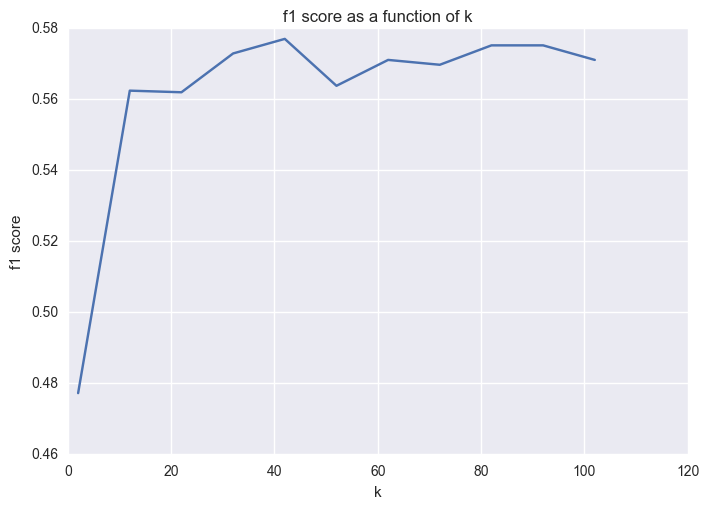

In [54]:
k_range = range(2,103,10)
val_scores = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_train_set, knn_train_labels)
    knn_val_pred = knn.predict(knn_val_set)
    val_f1 = metrics.f1_score(knn_val_labels, knn_val_pred, average='micro')
    print "validation score for k = %s:  %s" %(k, val_f1)
    val_scores.append(val_f1)

best_k = k_range[val_scores.index(max(val_scores))]
plot_results(k_range, val_scores, "f1 score", "k")

### Fit and evaluate by best parameter found

validation score for k = 50:  0.567851
validation score for k = 52:  0.563752
validation score for k = 54:  0.565118
validation score for k = 56:  0.564208
validation score for k = 58:  0.563752
validation score for k = 60:  0.566940
validation score for k = 62:  0.571038
validation score for k = 64:  0.568306
validation score for k = 66:  0.565574
validation score for k = 68:  0.564663


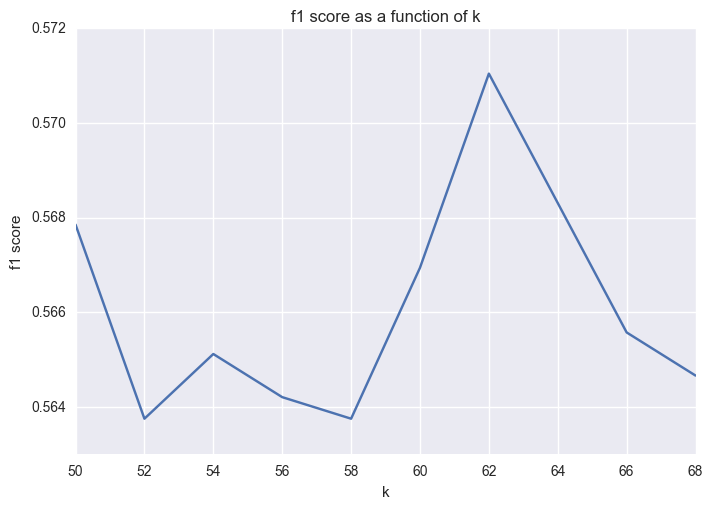

KNN - 4 BINS VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.64      0.64      0.64       496
      BIN_1       0.43      0.42      0.43       576
      BIN_2       0.47      0.57      0.52       568
      BIN_3       0.83      0.67      0.74       556

avg / total       0.59      0.57      0.58      2196


Confusion matrix with 4 bins: 
[[317 152  26   1]
 [132 244 190  10]
 [ 35 144 322  67]
 [ 10  32 143 371]]


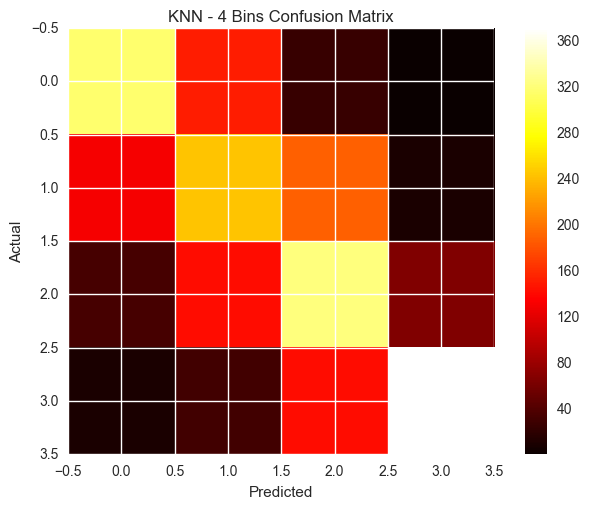


KNN - 4 Bins validation f1-score:0.571038251366


0.57103825136612019

In [55]:
k_range = range(50,70,2)

best_f1 = 0
knn_best_preds = []
val_scores = []
for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(knn_train_set, knn_train_labels)
    knn_val_pred = knn.predict(knn_val_set)
    knn_val_pred_probs = knn.predict_proba(knn_val_set)
    val_f1 = metrics.f1_score(knn_val_labels, knn_val_pred, average='micro')
    if val_f1 > best_f1:
        best_f1 = val_f1
        knn_best_preds = [knn_val_pred, knn_val_pred_probs]
    print "validation score for k = %d:  %f" %(k, val_f1)
    val_scores.append(val_f1)

plot_results(k_range, val_scores, "f1 score", "k")
eval_model("KNN - 4 Bins", knn_val_labels, knn_best_preds[0], knn_best_preds[1], 
           is_val=True, bin_num=4)

### KNN PCA run

validation score for k = 50:  0.569217
validation score for k = 52:  0.566029
validation score for k = 54:  0.564663
validation score for k = 56:  0.562386
validation score for k = 58:  0.566485
validation score for k = 60:  0.568306
validation score for k = 62:  0.571494
validation score for k = 64:  0.566485
validation score for k = 66:  0.565574
validation score for k = 68:  0.564208


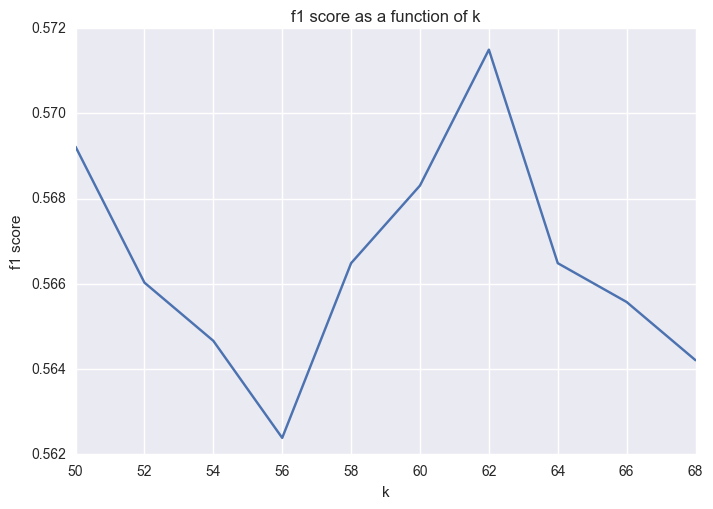

KNN - 4 BINS VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.64      0.64      0.64       496
      BIN_1       0.43      0.42      0.43       576
      BIN_2       0.47      0.57      0.52       568
      BIN_3       0.82      0.67      0.74       556

avg / total       0.59      0.57      0.58      2196


Confusion matrix with 4 bins: 
[[317 152  26   1]
 [132 244 189  11]
 [ 33 144 324  67]
 [ 10  31 145 370]]


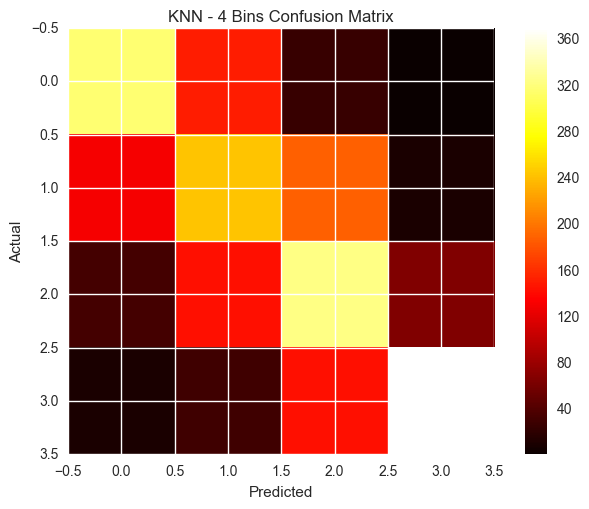


KNN - 4 Bins validation f1-score:0.571493624772


0.57149362477231325

In [56]:
knn_set = knn_train_set.append(knn_val_set, ignore_index=True)

pca = PCA(int(knn_train_set.shape[1] * 0.8))
pca.fit(knn_train_set)
pca_knn_set = pca.transform(knn_set)
pca_knn_train_set = pca_knn_set[:knn_train_set.shape[0]]
pca_knn_val_set = pca_knn_set[knn_train_set.shape[0]:]

k_range = range(50,70,2)
best_f1 = 0
knn_best_preds = []
val_scores = []

for k in k_range:
    knn = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
    knn.fit(pca_knn_train_set, knn_train_labels)
    knn_val_pred = knn.predict(pca_knn_val_set)
    knn_val_pred_probs = knn.predict_proba(pca_knn_val_set)
    val_f1 = metrics.f1_score(knn_val_labels, knn_val_pred, average='micro')
    if val_f1 > best_f1:
        best_f1 = val_f1
        knn_best_preds = [knn_val_pred, knn_val_pred_probs]
    print "validation score for k = %d:  %f" %(k, val_f1)
    val_scores.append(val_f1)

plot_results(k_range, val_scores, "f1 score", "k")
eval_model("KNN - 4 Bins", knn_val_labels, knn_best_preds[0], knn_best_preds[1], 
           is_val=True, bin_num=4)

## Random Forest

### Utils

In [57]:
def rf_feature_sel_param_opt(rf_train_set, rf_val_set, rf_train_labels, rf_val_labels):
    forest = RandomForestClassifier(n_estimators=250, max_depth=15)
    forest.fit(rf_train_set.values, rf_train_labels.values)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking - Top 10:")
    for f in range(10):
        print("%d. feature %d (%s)\n   score: %f" % (f + 1, indices[f], list(rf_train_set)[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plot_idxs = indices[:20]
    plt.figure()
    plt.title("Feature importances (Top 20)")
    plt.bar(range(20), importances[plot_idxs],
           color="r", yerr=std[plot_idxs], align="center")
    plt.xticks(range(20), plot_idxs)
    plt.xlim([-1, 21])
    plt.show()
    
    importances_thresholds = [0, 0.005, 0.01, 0.015, 0.02]
    max_depths = [10, 20, 30, None] 
    min_samples_leaf = [1, 3, 5]

    filtered_by_thresholds = []
    for t in importances_thresholds:
        columns = []
        for f in range(rf_train_set.shape[1]):
            if importances[indices[f]] >= t:
                columns.append(list(rf_train_set)[indices[f]])
        filtered_by_thresholds.append(columns)

    params = []
    score_summary = []
    oobs = []
    print "(threshold, depth, min_samples) -> average precision score, oob error"
    for i in range(len(filtered_by_thresholds)):
        for d in max_depths:
            for l in min_samples_leaf:
                cols = filtered_by_thresholds[i]
                forest = RandomForestClassifier(n_estimators=250, random_state=0, oob_score=True, max_depth=d, min_samples_leaf=l)
                forest.fit(rf_train_set[cols], rf_train_labels)
                temp_predictions = forest.predict(rf_val_set[cols])
                res = metrics.precision_score(rf_val_labels, temp_predictions, average='macro')
                oob_error = 1 - forest.oob_score_
                score_summary.append(res)
                oobs.append(oob_error)
                params.append((importances_thresholds[i], d, l))
                print "params: %s -> precision: %s, oob error: %s" % (params[-1], score_summary[-1], oobs[-1])

    max_idx = np.argmax(score_summary)
    best_threshold = params[max_idx][0]
    best_max_depth = params[max_idx][1]
    best_min_leaf = params[max_idx][2]

    # Print best hyper parameters
    print "RF best parameters:"
    print "max_depth = ", best_max_depth
    print "importance_threshold = ", best_threshold
    print "min_samples_leaf = ", best_min_leaf

    fc = filtered_by_thresholds[importances_thresholds.index(best_threshold)]
    return fc, best_max_depth, best_min_leaf

### Data preparation

In [58]:
rf_train_set = train_set.copy()
rf_val_set = val_set.copy()

### Feature selection and parameter optimization - 4 bins

Feature ranking - Top 10:
1. feature 114 (linr_predict)
   score: 0.086360
2. feature 112 (lr_predict_1)
   score: 0.079901
3. feature 113 (lr_predict_2)
   score: 0.071556
4. feature 111 (lr_predict_0)
   score: 0.071336
5. feature 81 (talking_about_count)
   score: 0.042659
6. feature 53 (self_feed_avg_likes)
   score: 0.033089
7. feature 74 (self_feed_std_likes)
   score: 0.030316
8. feature 62 (self_feed_max_likes)
   score: 0.025276
9. feature 16 (photo_max_like)
   score: 0.023956
10. feature 26 (total_photos)
   score: 0.022777


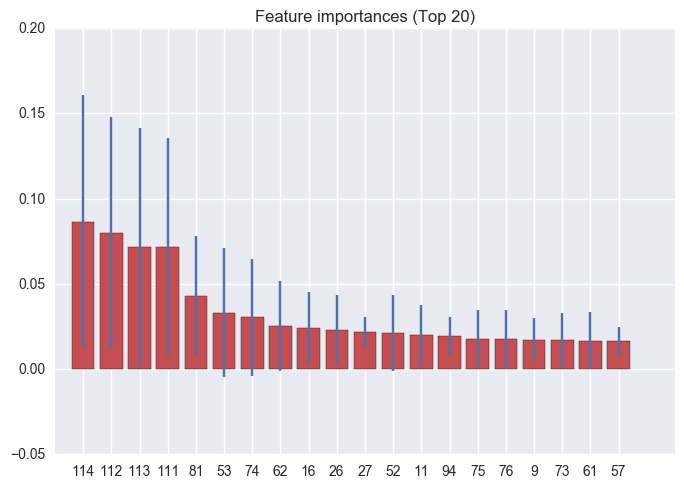

(threshold, depth, min_samples) -> average precision score, oob error
params: (0, 10, 1) -> precision: 0.649941753941, oob error: 0.36028239581
params: (0, 10, 3) -> precision: 0.652699606102, oob error: 0.362218173537
params: (0, 10, 5) -> precision: 0.652010272787, oob error: 0.363356866317
params: (0, 20, 1) -> precision: 0.662819846378, oob error: 0.361876565703
params: (0, 20, 3) -> precision: 0.659816919777, oob error: 0.358574356639
params: (0, 20, 5) -> precision: 0.656313772676, oob error: 0.35789114097
params: (0, 30, 1) -> precision: 0.65510122914, oob error: 0.355727624687
params: (0, 30, 3) -> precision: 0.655620708989, oob error: 0.360396265088
params: (0, 30, 5) -> precision: 0.657906746634, oob error: 0.358118879526
params: (0, None, 1) -> precision: 0.659588811006, oob error: 0.354247324072
params: (0, None, 3) -> precision: 0.65611888591, oob error: 0.359713049419
params: (0, None, 5) -> precision: 0.657906746634, oob error: 0.358118879526
params: (0.005, 10, 1) -> pr

In [59]:
rf_train_labels = train_labels['4_bin_labels'].copy()
rf_val_labels = val_labels['4_bin_labels'].copy()

fc, best_max_depth, best_min_leaf = rf_feature_sel_param_opt(rf_train_set, rf_val_set, rf_train_labels, rf_val_labels)

### Model evaluation - 4 bins

RANDOM FOREST VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.73      0.77      0.75       496
      BIN_1       0.54      0.57      0.56       576
      BIN_2       0.55      0.56      0.56       568
      BIN_3       0.83      0.73      0.77       556

avg / total       0.66      0.65      0.66      2196


Confusion matrix with 4 bins: 
[[382 104  10   0]
 [117 329 123   7]
 [ 21 150 319  78]
 [  3  21 128 404]]


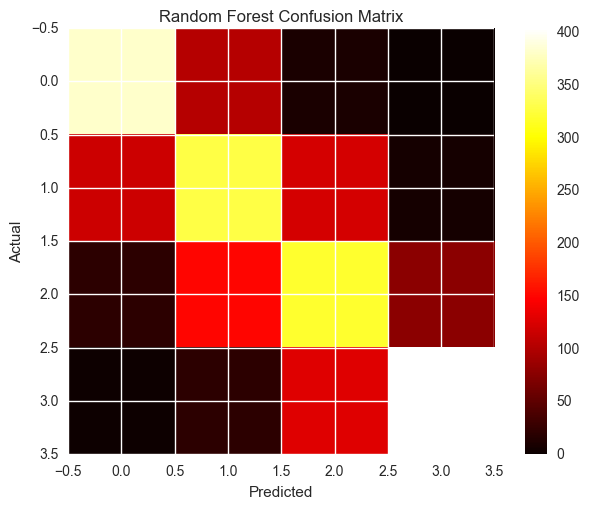


Random Forest validation f1-score:0.653005464481


In [60]:
forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_train_predictions = forest.predict(rf_train_set[fc])
rf_val_predicted_probs = forest.predict_proba(rf_val_set[fc])
rf_val_predictions = forest.predict(rf_val_set[fc])

f1_score = eval_model("Random Forest", rf_val_labels, rf_val_predictions, rf_val_predicted_probs, 
           is_val=True, bin_num=4)

### Feature selection and parameter optimization - 8 bins

Feature ranking - Top 10:
1. feature 114 (linr_predict)
   score: 0.066334
2. feature 112 (lr_predict_1)
   score: 0.061309
3. feature 113 (lr_predict_2)
   score: 0.051226
4. feature 111 (lr_predict_0)
   score: 0.050078
5. feature 81 (talking_about_count)
   score: 0.039364
6. feature 16 (photo_max_like)
   score: 0.027084
7. feature 62 (self_feed_max_likes)
   score: 0.026457
8. feature 53 (self_feed_avg_likes)
   score: 0.025509
9. feature 11 (photo_avg_likes_per_photo)
   score: 0.023349
10. feature 74 (self_feed_std_likes)
   score: 0.023208


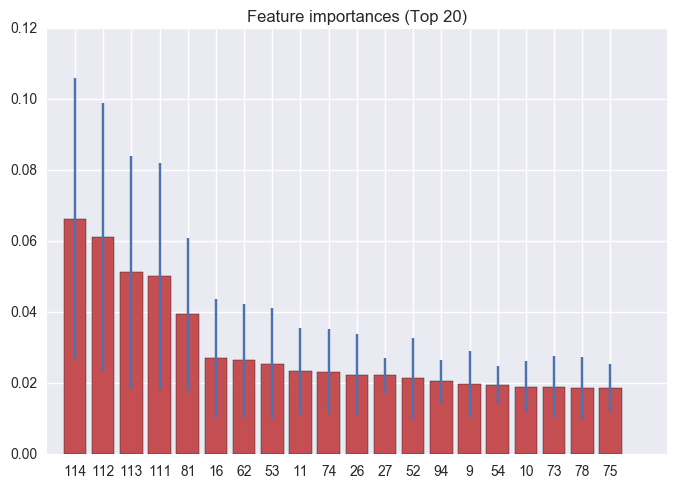

(threshold, depth, min_samples) -> average precision score, oob error
params: (0, 10, 1) -> precision: 0.415217274744, oob error: 0.588020951947
params: (0, 10, 3) -> precision: 0.421190180047, oob error: 0.583352311546
params: (0, 10, 5) -> precision: 0.418269280453, oob error: 0.587337736279
params: (0, 20, 1) -> precision: 0.41658072277, oob error: 0.591892507402
params: (0, 20, 3) -> precision: 0.420552058023, oob error: 0.58904577545
params: (0, 20, 5) -> precision: 0.420356068158, oob error: 0.588362559781
params: (0, 30, 1) -> precision: 0.414905160311, oob error: 0.593258938738
params: (0, 30, 3) -> precision: 0.41464236322, oob error: 0.588020951947
params: (0, 30, 5) -> precision: 0.407343517092, oob error: 0.584377135049
params: (0, None, 1) -> precision: 0.414120470069, oob error: 0.594511500797
params: (0, None, 3) -> precision: 0.417739409686, oob error: 0.586996128445
params: (0, None, 5) -> precision: 0.405565734622, oob error: 0.584491004327
params: (0.005, 10, 1) -> p

In [61]:
rf_train_labels = train_labels['8_bin_labels'].copy()
rf_val_labels = val_labels['8_bin_labels'].copy()

fc, best_max_depth, best_min_leaf = rf_feature_sel_param_opt(rf_train_set, rf_val_set, rf_train_labels, rf_val_labels)

### Model evaluation - 8 bins

RANDOM FOREST VALIDATION RESULTS

Classification report:
             precision    recall  f1-score   support

      BIN_0       0.61      0.65      0.63       226
      BIN_1       0.37      0.49      0.42       270
      BIN_2       0.34      0.31      0.32       272
      BIN_3       0.32      0.27      0.29       304
      BIN_4       0.29      0.28      0.29       282
      BIN_5       0.30      0.31      0.31       286
      BIN_6       0.44      0.38      0.41       312
      BIN_7       0.70      0.73      0.71       244

avg / total       0.41      0.41      0.41      2196


Confusion matrix with 8 bins: 
[[147  67   9   3   0   0   0   0]
 [ 58 133  47  26   5   1   0   0]
 [ 21  82  84  46  33   3   3   0]
 [  8  43  56  81  62  47   7   0]
 [  6  21  29  58  80  61  26   1]
 [  0   9  18  28  67  89  66   9]
 [  0   6   5  10  24  82 118  67]
 [  0   0   2   2   2  13  47 178]]


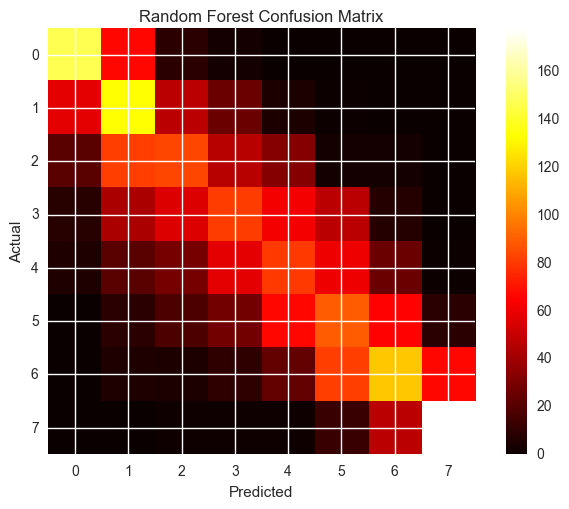


Random Forest validation f1-score:0.414389799636

1-Bin-Away scores:
Avg Precision: 0.815274884701
Avg Recall: 0.817962710263
Avg f1-score: 0.812802799679


In [62]:
forest = RandomForestClassifier(n_estimators=250, random_state=0, max_depth=best_max_depth, min_samples_leaf=best_min_leaf, oob_score=True)
forest.fit(rf_train_set[fc].values, rf_train_labels)
rf_train_predicted_probs = forest.predict_proba(rf_train_set[fc])
rf_train_predictions = forest.predict(rf_train_set[fc])
rf_val_predicted_probs = forest.predict_proba(rf_val_set[fc])
rf_val_predictions = forest.predict(rf_val_set[fc])

f1_score = eval_model("Random Forest", rf_val_labels, rf_val_predictions, rf_val_predicted_probs, 
           is_val=True, bin_num=8)

## Logistic Regression

### Generate feature selection combinations (save/load from disk to save time)

In [65]:
# Getting feature selections from disk

# feat_sel_list = get_feat_sel(train_set, val_set, train_labels['4_bin_labels'], val_labels['4_bin_labels'], lm.LogisticRegression(penalty='l2', C=1), verbose=True)
# with open('data_sets_LR.json', 'w') as lrf:
#     lrf.write(json.dumps(feat_sel_list))

with open('data_sets_LR.json', 'r') as lrf:
    feat_sel_list = json.loads(lrf.read())

In [ ]:
bla

### Preprocessing - preparing different data sets and removing outliers (Grubbs) from selected features

In [ ]:
lr_train_set = train_set.copy()
lr_val_set = val_set.copy()
lr_train_labels = train_labels.copy()
lr_val_labels = val_labels.copy()

lr_data_sets = [(lr_train_set, lr_val_set, lr_train_labels, lr_val_labels)]

for feat_sel in feat_sel_list[:3]:
    feats_to_remove_by = [feat for feat in feat_sel['selected_feats'] if set(pp_data[feat].unique()) != {-1,1}]
    lr_pp_data = grubbs_outlier_removal(pp_data, feats_to_remove_by, verbose=True)
    lr_train_len = int(lr_pp_data.shape[0] * 0.8)
    
    lr_train_labels = lr_pp_data[['likes', '4_bin_labels', '8_bin_labels']][:lr_train_len].copy()
    lr_val_labels = lr_pp_data[['likes', '4_bin_labels', '8_bin_labels']][lr_train_len:].copy()

    lr_temp_pp_data = lr_pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
    lr_train_set = lr_temp_pp_data[feat_sel['selected_feats']][:lr_train_len].copy()
    lr_val_set = lr_temp_pp_data[feat_sel['selected_feats']][lr_train_len:].copy()
    
    lr_data_sets.append((lr_train_set, lr_val_set, lr_train_labels, lr_val_labels))


grubbs_outlier_removal: Got 39 feats to remove outliers by. STARTING...

grubbs_outlier_removal: feat photo_avg_likes_per_photo - 72 samples removed, 10906 samples left
grubbs_outlier_removal: feat feed_avg_likes_per_comment - 4 samples removed, 10902 samples left
grubbs_outlier_removal: feat feed_min_comments - 94 samples removed, 10808 samples left
grubbs_outlier_removal: feat feed_min_likes - 100 samples removed, 10708 samples left
grubbs_outlier_removal: feat feed_number_of_added_photos_category - 17 samples removed, 10691 samples left
grubbs_outlier_removal: feat feed_number_of_other_categories - 75 samples removed, 10616 samples left
grubbs_outlier_removal: feat feed_avg_shares - 11 samples removed, 10605 samples left
grubbs_outlier_removal: feat feed_max_shares - 5 samples removed, 10600 samples left
grubbs_outlier_removal: feat self_feed_avg_likes_per_comment - 3 samples removed, 10597 samples left
grubbs_outlier_removal: feat self_feed_avg_people_tagged_per_post - 1 samples r

### Grid Search for best hyper params

In [ ]:
estimators = [[],[]]
for bin_num in (4, 8):
    for ds in lr_data_sets:
        lr_train_set, lr_val_set, lr_train_labels, lr_val_labels = ds
        lr_train_labels = lr_train_labels['%s_bin_labels' % bin_num]
        lr_val_labels = lr_val_labels['%s_bin_labels' % bin_num]
        
        print("Fitting the classifier to the training set")
        param_grid = {'C': np.logspace(-1,3, num=8)}
        clf = GridSearchCV(lm.LogisticRegression(max_iter=200, solver='newton-cg', multi_class='multinomial'), param_grid, verbose=True)

        clf.fit(lr_train_set, lr_train_labels)
        print("Best estimator found by grid search (%s bins, %s feats):" % (bin_num, lr_train_set.shape[1]))
        print(clf.best_estimator_)
        estimators[bin_num/4 - 1].append(clf.best_estimator_)

Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/Users/guysalama/anaconda2/lib/python2.7/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 16.7min finished


Best estimator found by grid search (4 bins, 115 feats):
LogisticRegression(C=0.10000000000000001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  9.9min finished


Best estimator found by grid search (4 bins, 55 feats):
LogisticRegression(C=5.1794746792312099, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  5.0min finished


Best estimator found by grid search (4 bins, 75 feats):
LogisticRegression(C=1.3894954943731375, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   19.7s finished


Best estimator found by grid search (4 bins, 37 feats):
LogisticRegression(C=71.96856730011514, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='multinomial', n_jobs=1, penalty='l2',
          random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
          warm_start=False)
Fitting the classifier to the training set
Fitting 3 folds for each of 8 candidates, totalling 24 fits


### Fit and evaluate by best estimators found

In [ ]:
best_score = [0, 0]
best_score_idx = [0, 0]
for bin_num in (4, 8):
    for i in range(len(lr_data_sets)):
        ds = lr_data_sets[i]
        lr_train_set, lr_val_set, lr_train_labels, lr_val_labels = ds
        lr_train_labels = lr_train_labels['%s_bin_labels' % bin_num]
        lr_val_labels = lr_val_labels['%s_bin_labels' % bin_num]
        
        lr = estimators[bin_num/4 - 1][i]
        print "training logistic regression (%s bins, %s feats):" % (bin_num, lr_train_set.shape[1])
        lr.fit(lr_train_set, lr_train_labels)
        print "getting logistic regression predictions"
        lr_predicted_probs = lr.predict_proba(lr_train_set.append(lr_val_set, ignore_index=True))[:, 1]
        lr_predictions = lr.predict(lr_train_set.append(lr_val_set, ignore_index=True))

        lr_train_predicted_probs = lr_predicted_probs[:lr_train_set.shape[0]]
        lr_val_predicted_probs = lr_predicted_probs[lr_train_set.shape[0]:]

        lr_train_predictions = lr_predictions[:lr_train_set.shape[0]]
        lr_val_predictions = lr_predictions[lr_train_set.shape[0]:]
        
        run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, lr_train_set.shape[1]), lr_val_labels, lr_val_predictions, lr_val_predicted_probs, True, bin_num)
        
        if run_score > best_score[bin_num/4 - 1]:
            best_score[bin_num/4 - 1] = run_score
            best_score_idx[bin_num/4 - 1] = i

### Best model predictions

In [ ]:
print "best_score_idx - ", best_score_idx

for bin_num in (4, 8):
    print "%s Bins Logistic Regression Final Results:" % bin_num
    print "=========================================\n"
    best_results_idx = best_score_idx[bin_num/4 - 1]
    lr_train_set, lr_val_set, lr_train_labels, lr_val_labels = lr_data_sets[best_results_idx]
    lr_train_labels = lr_train_labels['%s_bin_labels' % bin_num]
    lr_val_labels = lr_val_labels['%s_bin_labels' % bin_num]
    lr = estimators[bin_num/4 - 1][best_results_idx]
    print "Using best estimator - ", lr
    
    lr_val_predicted_probs = lr.predict_proba(lr_val_set)[:, 1]
    lr_val_predictions = lr.predict(lr_val_set)
    
    if best_results_idx > 0:
        feats = feat_sel_list[best_results_idx - 1]['selected_feats']
        print "Got best results for %s selected features:\n%s" % (len(feats), '\n'.join(feats))
    
    run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, lr_train_set.shape[1]), lr_val_labels, lr_val_predictions, lr_val_predicted_probs, True, bin_num)

### PCA run

In [ ]:
# for bin_num in (4, 8):
#     best_results_idx = scores[bin_num/4 - 1].index(max(scores[bin_num/4 - 1]))
#     lr_train_set, lr_val_set, lr_train_labels, lr_val_labels = lr_data_sets[best_results_idx]
#     lr_train_labels = lr_train_labels['%s_bin_labels' % bin_num]
#     lr_val_labels = lr_val_labels['%s_bin_labels' % bin_num]
#     lr = estimators[bin_num/4 - 1][best_results_idx]
#     lr.fit(lr_train_set, lr_train_labels)
    
#     if best_results_idx > 0:
#         feats = feat_sel_list[best_results_idx - 1]['selected_feats']
#         print "Got best results for %s selected features:\n%s" % (len(feats), '\n'.join(feats))
    
#     run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, lr_train_set.shape[0]), lr_val_labels, lr_val_predictions, lr_val_predicted_probs, True, bin_num)

# SVM

### Generate preprocessed data sets (save/load from disk to save time)

In [ ]:
# Getting feature selections from disk

# feat_sel_list = get_feat_sel(train_set, val_set, train_labels['4_bin_labels'], val_labels['4_bin_labels'], svm.SVC(class_weight='balanced', C=100, kernel='linear'), verbose=True)
# with open('data_sets_SVM.json', 'w') as svmf:
#     svmf.write(json.dumps(feat_sel_list))

with open('data_sets_SVM.json', 'r') as svmf:
    feat_sel_list = json.loads(svmf.read())

### Preprocessing - preparing different data sets and removing outliers (Grubbs) from selected features

In [ ]:
svm_train_set = train_set.copy()
svm_val_set = val_set.copy()
svm_train_labels = train_labels.copy()
svm_val_labels = val_labels.copy()

svm_data_sets = [(svm_train_set, svm_val_set, svm_train_labels, svm_val_labels)]

for feat_sel in feat_sel_list[:2]:
    feats_to_remove_by = [feat for feat in feat_sel['selected_feats'] if set(pp_data[feat].unique()) != {-1,1}]
    svm_pp_data = grubbs_outlier_removal(pp_data, feats_to_remove_by, verbose=True)
    svm_train_len = int(svm_pp_data.shape[0] * 0.8)
    
    svm_train_labels = svm_pp_data[['likes', '4_bin_labels', '8_bin_labels']][:svm_train_len].copy()
    svm_val_labels = svm_pp_data[['likes', '4_bin_labels', '8_bin_labels']][svm_train_len:].copy()

    svm_temp_pp_data = svm_pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
    svm_train_set = svm_temp_pp_data[feat_sel['selected_feats']][:svm_train_len].copy()
    svm_val_set = svm_temp_pp_data[feat_sel['selected_feats']][svm_train_len:].copy()
    
    svm_data_sets.append((svm_train_set, svm_val_set, svm_train_labels, svm_val_labels))

### Grid Search for best hyper params

In [ ]:
estimators = [[],[]]
for bin_num in (4, 8):
    for ds in svm_data_sets:
        svm_train_set, svm_val_set, svm_train_labels, svm_val_labels = ds
        svm_train_labels = svm_train_labels['%s_bin_labels' % bin_num]
        svm_val_labels = svm_val_labels['%s_bin_labels' % bin_num]
        
        print("Fitting the classifier to the training set")
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'kernel': ['rbf', 'linear']}
        clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid)
        
        clf.fit(svm_train_set, svm_train_labels)
        print("Best estimator found by grid search (%s bins, %s feats):" % (bin_num, svm_train_set.shape[1]))
        print(clf.best_estimator_)
        estimators[bin_num/4 - 1].append(clf.best_estimator_)

### Fit and evaluate by best estimators found

In [ ]:
best_score = [0, 0]
best_score_idx = [0, 0]
for bin_num in (4, 8):
    for i in range(len(svm_data_sets)):
        ds = svm_data_sets[i]
        svm_train_set, svm_val_set, svm_train_labels, svm_val_labels = ds
        svm_train_labels = svm_train_labels['%s_bin_labels' % bin_num]
        svm_val_labels = svm_val_labels['%s_bin_labels' % bin_num]
        
        svm = estimators[bin_num/4 - 1][i]
        print "training logistic regression (%s bins, %s feats):" % (bin_num, svm_train_set.shape[1])
        svm.fit(svm_train_set, svm_train_labels)
        print "getting logistic regression predictions"
        svm_predicted_probs = svm.predict_proba(svm_train_set.append(svm_val_set, ignore_index=True))[:, 1]
        svm_predictions = svm.predict(svm_train_set.append(svm_val_set, ignore_index=True))

        svm_train_predicted_probs = svm_predicted_probs[:svm_train_set.shape[0]]
        svm_val_predicted_probs = svm_predicted_probs[svm_train_set.shape[0]:]

        svm_train_predictions = svm_predictions[:svm_train_set.shape[0]]
        svm_val_predictions = svm_predictions[svm_train_set.shape[0]:]
        
        run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, svm_train_set.shape[1]), svm_val_labels, svm_val_predictions, svm_val_predicted_probs, True, bin_num)
        
        if run_score > best_score[bin_num/4 - 1]:
            best_score[bin_num/4 - 1] = run_score
            best_score_idx[bin_num/4 - 1] = i

### Best model predictions

In [ ]:
print "best_score_idx - ", best_score_idx

for bin_num in (4, 8):
    print "%s Bins SVM Final Results:" % bin_num
    print "=========================\n"
    best_results_idx = best_score_idx[bin_num/4 - 1]
    svm_train_set, svm_val_set, svm_train_labels, svm_val_labels = svm_data_sets[best_results_idx]
    svm_train_labels = svm_train_labels['%s_bin_labels' % bin_num]
    svm_val_labels = svm_val_labels['%s_bin_labels' % bin_num]
    svm = estimators[bin_num/4 - 1][best_results_idx]
    print "Using estimator - ", svm
    
    svm_val_predicted_probs = svm.predict_proba(svm_val_set)[:, 1]
    svm_val_predictions = svm.predict(svm_val_set)
    
    if best_results_idx > 0:
        feats = feat_sel_list[best_results_idx - 1]['selected_feats']
        print "Got best results for %s selected features:\n%s" % (len(feats), '\n'.join(feats))
    
    run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, svm_train_set.shape[1]), svm_val_labels, svm_val_predictions, svm_val_predicted_probs, True, bin_num)

### PCA run

In [ ]:
# for bin_num in (4, 8):
#     best_results_idx = scores[bin_num/4 - 1].index(max(scores[bin_num/4 - 1]))
#     svm_train_set, svm_val_set, svm_train_labels, svm_val_labels = svm_data_sets[best_results_idx]
#     svm_train_labels = svm_train_labels['%s_bin_labels' % bin_num]
#     svm_val_labels = svm_val_labels['%s_bin_labels' % bin_num]
#     lr = estimators[bin_num/4 - 1][best_results_idx]
#     lr.fit(svm_train_set, svm_train_labels)
    
#     if best_results_idx > 0:
#         feats = feat_sel_list[best_results_idx - 1]['selected_feats']
#         print "Got best results for %s selected features:\n%s" % (len(feats), '\n'.join(feats))
    
#     run_score = eval_model("Logistic Regression (%s bins, %s feats)" % (bin_num, svm_train_set.shape[0]), svm_val_labels, svm_val_predictions, svm_val_predicted_probs, True, bin_num)

## Lasso Regression

### Generate preprocessed data sets (save/load from disk to save time)

In [ ]:
# Getting feature selections from disk

# feat_sel_list = get_feat_sel(train_set, val_set, train_labels['likes'], val_labels['likes'], lm.Lasso(), verbose=True)
# with open('data_sets_LASSO.json', 'w') as lassof:
#     lassof.write(json.dumps(feat_sel_list))

with open('data_sets_LASSO.json', 'r') as lassof:
    feat_sel_list = json.loads(lassof.read())

### Preprocessing - preparing different data sets and removing outliers (Grubbs) from selected features

In [ ]:
lasso_train_set = train_set.copy()
lasso_val_set = val_set.copy()
lasso_train_labels = train_labels.copy()
lasso_val_labels = val_labels.copy()

lasso_data_sets = [(lasso_train_set, lasso_val_set, lasso_train_labels, lasso_val_labels)]

for feat_sel in feat_sel_list[:3]:
    feats_to_remove_by = [feat for feat in feat_sel['selected_feats'] if set(pp_data[feat].unique()) != {-1,1}]
    lasso_pp_data = grubbs_outlier_removal(pp_data, feats_to_remove_by, verbose=True)
    lasso_train_len = int(lasso_pp_data.shape[0] * 0.8)
    
    lasso_train_labels = lasso_pp_data[['likes', '4_bin_labels', '8_bin_labels']][:lasso_train_len].copy()
    lasso_val_labels = lasso_pp_data[['likes', '4_bin_labels', '8_bin_labels']][lasso_train_len:].copy()

    lasso_temp_pp_data = lasso_pp_data.drop(['likes', 'id', '4_bin_labels', '8_bin_labels'], 1, errors='ignore')
    lasso_train_set = lasso_temp_pp_data[feat_sel['selected_feats']][:lasso_train_len].copy()
    lasso_val_set = lasso_temp_pp_data[feat_sel['selected_feats']][lasso_train_len:].copy()

    lasso_data_sets.append((lasso_train_set, lasso_val_set, lasso_train_labels, lasso_val_labels))

### Fit and evaluate by best feature combination

In [ ]:
best_score = 0
best_score_idx = 0
best_est = None
for i in range(len(lasso_data_sets)):
    ds = lasso_data_sets[i]
    lasso_train_set, lasso_val_set, lasso_train_labels, lasso_val_labels = ds
    lasso_train_labels = lasso_train_labels['likes'].apply(_log)
    lasso_val_labels = lasso_val_labels['likes'].apply(_log)

    
    # Compute paths
    print("Computing regularization path using the coordinate descent lasso... (%s feats)" % lasso_train_set.shape[1])
    t1 = time.time()
    # Display results
    lasso = lm.LassoCV(cv=120)
    lasso.fit(lasso_train_set, lasso_train_labels)
    m_log_alphas = -np.log10(lasso.alphas_)
    t_lasso_cv = time.time() - t1

    # plot
    plt.figure()
    plt.plot(m_log_alphas, lasso.mse_path_, ':')
    plt.plot(m_log_alphas, lasso.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(lasso.alpha_), linestyle='--', color='k',
                label='alpha: CV estimate')

    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error on each fold: coordinate descent '
              '(train time: %.2fs)' % t_lasso_cv)
    plt.axis('tight')

    # The mean squared error
    print "Mean squared error: %.2f" %(np.mean((lasso.predict(lasso_train_set) - lasso_train_labels) ** 2))
    # Explained variance score: 1 is perfect prediction
    print 'training variance score: %.2f' %(lasso.score(lasso_train_set, lasso_train_labels))
    print 'validation variance score: %.2f\n\n' %(lasso.score(lasso_val_set, lasso_val_labels))
    
    if lasso.score(lasso_val_set, lasso_val_labels) > best_score:
        best_score = lasso.score(lasso_val_set, lasso_val_labels)
        best_score_idx = i
        best_est = lasso

### Best model predictions

In [ ]:
lasso_train_set, lasso_val_set, lasso_train_labels, lasso_val_labels = lasso_data_sets[best_score_idx]

lasso_val_likes = lasso_val_labels['likes'].copy()
lasso_train_labels = lasso_train_labels['likes'].apply(_log)
lasso_val_labels = lasso_val_labels['likes'].apply(_log)

lasso = best_est
print "training Lasso (%s feats):" % (lasso_train_set.shape[1])
lasso.fit(lasso_train_set, lasso_train_labels)
print "getting Lasso predictions"
lasso_predictions = lasso.predict(lasso_train_set.append(lasso_val_set, ignore_index=True))

lasso_train_predictions = lasso_predictions[:lasso_train_set.shape[0]]
lasso_val_predictions = lasso_predictions[lasso_train_set.shape[0]:]

# The mean squared error
print "\n\nMean squared error: %.2f" %(np.mean((lasso.predict(lasso_train_set) - lasso_train_labels) ** 2))
# Explained variance score: 1 is perfect prediction
print 'training variance score: %.2f' %(lasso.score(lasso_train_set, lasso_train_labels))
print 'validation variance score: %.2f' %(lasso.score(lasso_val_set, lasso_val_labels))
    
plt.scatter(lasso_train_predictions, lasso_train_predictions - lasso_train_labels, c='b', s=40, alpha=0.5)
plt.scatter(lasso_val_predictions, lasso_val_predictions - lasso_val_labels, c='g', alpha=0.5)
plt.hlines(y=0, xmin=5, xmax=15)
plt.title('Residual plot test (green), train (blue)')
plt.ylabel('Residuals')
plt.show()

In [ ]:
val_exp_pred = np.exp(lasso_val_predictions)

for bin_num in [4,8]:
    val_pred_bins = binning(val_exp_pred, bin_num)

    lasso_val_set_bin_labels = binning(lasso_val_likes, bin_num)

    score = metrics.f1_score(lasso_val_set_bin_labels.values, val_pred_bins, average='micro')
    print "Lasso validation precision for %s bins: %s" %(bin_num, score)

    run_score = eval_model("Lasso (%s bins, %s feats)" % (bin_num, lasso_train_set.shape[1]), lasso_val_set_bin_labels, val_pred_bins, None, True, bin_num)